<a href="https://colab.research.google.com/github/imsmoothlikebutter/ICT3102-e-mc2-assignment-2/blob/main/ICT3102_Assignment2_shahzad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstract:**

This Jupyter Notebook and its code offer a thorough analysis of various language models' performance, using the Hugging Face Transformers library to assess their behavior across different prompts and generation settings. The study evaluates key models like bert-base-cased, bigscience/bloom-560m, and several others, focusing on memory use and response times during text generation. It examines different generation parameters, such as default settings, beam search, and sampling, to determine their impact on performance. Additionally, the study provides an in-depth look at the distribution of response times across models and beam types, analyzing the effects of beam width and the average time for each parameter. It also includes a detailed comparison of model parameters and tracks memory usage before and after text generation, thereby offering insights into the computational efficiency of various models and techniques. The study comprehensively covers all critical aspects, including response time distribution, beam width effects, and model parameter comparison.


# **Methodology:**

1. **Importing Libraries:** The code initiates with importing essential Python libraries and modules. These include transformers for language models, datasets for loading and processing data, pandas for data analysis, psutil for monitoring system resources, concurrent.futures for parallel processing, and json for data serialization.

2. **Loading Dataset:** The Self-Instruct-Seed dataset from HuggingFace is loaded. This dataset provides a diverse range of prompts for text generation.

3. **Defining Functions:**
   - `mem_report()`: This function measures and returns available system memory using the `psutil` library.
   - `get_model()`: This function uses AutoModelForCausalLM to retrieve the model for the corresponding checkpoint.
   - `measure_response_time()`: This function quantifies the time taken for generating text with a given model and input prompt.
   - `get_model_parameters()`: This function retrieves the number of parameters in a given model.
   - `generate()`: This function analyze default token generation.
   - `generate_token_with_beam()`: This function analyze token generation with beam.
   - `generate_token_without_beam_cache()`: This function analyze token generation with beam but without caching.
   - `random_sampling()`: This function analyze token generation with random sampling.
   - `split_corpus()`: This function splits the corpus into n_chunks.
   - `analyze_chunk()`: This function create 4 threads to handle analysis.
   - `run_analysis_on_checkpoint()`: This function runs analysis on checkpoint.
   - `categorize_results()`: This function categorizes the results into their analysis method.
   - `write_to_json()`: This function stores results to json file.

4. **Model Checkpoints:** A list of diverse language model checkpoints to be assessed is specified.
   - These models that were used in Assignment 1 was dropped due to the lack of support from AutoModel.
      - Distilbert-base
      - google/mobilebert-uncased
      - funnel-transformers/all-mpnet-base-v2
      - sentence-transformers/all-mpnet-base-v2
      - google/flan-t5-base
      - google/bigbird-roberta-base
      - albert-base
  - These models that were used in Assignment 1 was dropped due to Out Of Memory issue.
      - NousResearch/Llama-2-13b-hf

5. **Data Collection and Analysis:** The methodology includes a thorough process of data collection and analysis:

    - Iterating through each checkpoint.
    - Loading models and tokenizers for each checkpoint.
    - Running a series of text generations using different methods (default, beam search, beam without cache, and sampling).
    - Measuring memory usage and response time for each method.
    - Storing all results in a structured format.

6. **Result Categorization and Access:** Analysis results are categorized by their method (default, beam, etc.) and stored into separate JSON files for easy access and analysis.

7. **Data Presentation:** The collected results are converted into a unified Pandas DataFrame. The DataFrame is then sorted and saved to a CSV file for comprehensive presentation and further analysis.

8. **Additional Considerations:**
    - The methodology includes parallel processing techniques to optimize the analysis process.
    - Error handling and logging are implemented to ensure robustness.
    - The system is designed to be scalable and adaptable for different models and datasets.

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download zh_core_web_sm
!python -m spacy download es_core_news_sm
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install gdown
!pip install pandas ipywidgets
# Import packages
import os, sys, humanize, psutil
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Models that will be analyzed

In [ ]:
checkpoints = ["openai-gpt"] # Models from report 1
checkpoints.append("distilgpt2")
checkpoints.append("bert-base-cased")
checkpoints.append("google/bert_for_seq_generation_L-24_bbc_encoder")
checkpoints.append("bigscience/bloom-560m")
checkpoints.append("EleutherAI/gpt-neo-1.3B")

In [ ]:
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
import os,sys,humanize,psutil
import json
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import os

os.environ["TOKENIZERS_PARALLELISM"] = "True"

# Define function
def mem_report():
  """Returns available memory"""
  return psutil.virtual_memory().available

def get_model_parameters(model):
  """Returns the parameters for a given model."""
  return model.num_parameters()

def get_model(checkpoint):
  """Uses AutoModelForCausalLM to retrieve the model for the corresponding checkpoint."""
  try:
    model = AutoModelForCausalLM.from_pretrained(checkpoint, is_decoder=True)
    return model
  except Exception as e:
    print(f"Failed to retrieve model  from {checkpoint}")
    return None

def generate(tokenizer, prompt, inputs, checkpoint, model) -> dict:
    """Analyze default token generation"""
    # inputs = tokenizer(prompt, return_tensors="pt")
    model_parameters = get_model_parameters(model)
    mem_before = mem_report()
    start = time.time()
    outputs = model.generate(**inputs, pad_token_id=50256, max_new_tokens=40)
    end = time.time()
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    mem_after = mem_report()
    result = {
        "type": "Default",
        "checkpoint": checkpoint,
        "prompt": prompt,
        "response": decoded_output,
        "time": end - start,
        "mem_after": mem_after,
        "mem_before": mem_before,
        "consumed": mem_before - mem_after,
        "model_parameters": model_parameters
    }
    print(f"Time Taken for generate {result['time']}")
    return result

def generate_token_with_beam(tokenizer, prompt, inputs, checkpoint, model) -> dict:
    """Analyze token generatio with beam"""
    #inputs = tokenizer(prompt, return_tensors="pt")
    model_parameters = get_model_parameters(model)
    mem_before = mem_report()
    start = time.time()

    beam_output = model.generate(
        **inputs,
        max_new_tokens=40,
        pad_token_id=50256,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    end = time.time()

    decoded_output = tokenizer.batch_decode(beam_output[0], skip_special_tokens=True)
    mem_after = mem_report()
    result = {
        "type": "Beam",
        "checkpoint": checkpoint,
        "prompt": prompt,
        "response": decoded_output,
        "time": end - start,
        "mem_after": mem_after,
        "mem_before": mem_before,
        "consumed": mem_before - mem_after,
        "model_parameters": model_parameters
    }
    print(f"Time Taken for beam {result['time']}")
    return result

def generate_token_without_beam_cache(tokenizer,prompt, inputs, checkpoint, model) -> dict:
    """Analyze token generation with beam but without caching"""
    # inputs = tokenizer(prompt, return_tensors="pt")
    model_parameters = get_model_parameters(model)
    mem_before = mem_report()
    start = time.time()
    beam_output = model.generate(
        **inputs,
        max_new_tokens=40,
        pad_token_id=50256,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
        use_cache=False # Sets cacheing to fault (defaulted to true)
    )
    end = time.time()
    decoded_output = tokenizer.batch_decode(beam_output[0], skip_special_tokens=True)
    mem_after = mem_report()
    result = {
        "type": "Beam Without Cache",
        "checkpoint": checkpoint,
        "prompt": prompt,
        "response": decoded_output,
        "time": end - start,
        "mem_after": mem_after,
        "mem_before": mem_before,
        "consumed": mem_before - mem_after,
        "model_parameters": model_parameters
    }
    print(f"Time Taken for beam no cache {result['time']}")
    return result

def random_sampling(tokenizer, prompt, inputs, checkpoint, model):
    """Analyze token generation with random sampling"""
    #inputs = tokenizer(prompt, return_tensors="pt")
    model_parameters = get_model_parameters(model)
    mem_before = mem_report()
    start = time.time()
    beam_output = model.generate(
        **inputs,
        max_new_tokens=40,
        pad_token_id=50256,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    end = time.time()

    decoded_output = tokenizer.batch_decode(beam_output[0], skip_special_tokens=True)
    mem_after = mem_report()
    result = {
        "type": "Sampling",
        "checkpoint": checkpoint,
        "prompt": prompt,
        "response": decoded_output,
        "time": end - start,
        "mem_after": mem_after,
        "mem_before": mem_before,
        "consumed": mem_before - mem_after,
        "model_parameters": model_parameters
    }
    print(f"Time Taken for sampling {result['time']}")
    return result

def split_corpus(corpus, n_chunks):
    """Splits the corpus into n_chunks. Adjusts the number of chunks if it's greater than the size of the corpus."""
    # Ensure we don't create more chunks than there are elements in the corpus
    n_chunks = min(n_chunks, len(corpus))

    # If the number of chunks is 1 or the corpus is empty, return the corpus as is
    if n_chunks <= 1:
        return [corpus]

    chunk_size = len(corpus) // n_chunks
    chunks = [corpus[i:i + chunk_size] for i in range(0, len(corpus), chunk_size)]

    # If the last chunk is smaller than the others, append the remaining items to it
    if len(corpus) % n_chunks != 0:
        chunks[-1].extend(corpus[-(len(corpus) % n_chunks):])
    print(f"Corpus divided into {n_chunks} chunks, each containing {chunk_size} prompts.")
    return chunks

def analyze_chunk(args):
    """Performs analyses on each prompt in a chunk of the corpus and returns the combined results."""
    tokenizer, checkpoint, chunk, model = args
    results = []  # Local list to store results for the entire chunk
    for text in chunk:
        print(f"Analyzing: {text}")
        inputs = tokenizer(text, return_tensors="pt")
        single_result = analyze_one((tokenizer, text, checkpoint, inputs, model))
        results.extend(single_result)  # Append results for each text in the chunk
    return results

from concurrent.futures import ThreadPoolExecutor, as_completed

def analyze_one(args):
    """Create 4 threads to handle analysis."""
    tokenizer, prompt, checkpoint, tokenized_text, model = args
    tasks = [
        (generate, (tokenizer, prompt, tokenized_text, checkpoint, model)),
        (generate_token_with_beam, (tokenizer, prompt, tokenized_text, checkpoint, model)),
        (generate_token_without_beam_cache, (tokenizer, prompt, tokenized_text, checkpoint, model)),
        (random_sampling, (tokenizer, prompt, tokenized_text, checkpoint, model))
    ]

    results = []
    with ThreadPoolExecutor() as executor:
        # Submit all tasks and collect their futures
        future_to_task = {executor.submit(task, *task_args): task for task, task_args in tasks}

        # Iterate over the futures as they complete
        for future in as_completed(future_to_task):
            try:
                # Store the result of each future as it becomes available
                results.append(future.result())
            except Exception as e:
                # Handle exceptions and log errors
                print(f"Error in task: {e}")
                results.append(None)

    return results

def run_analysis_on_checkpoint(checkpoint, corpus):
    max_processes = max(os.cpu_count() - 4,2) # Fallback to 1 if cpu_count is None
    print(f"Running analysis on {checkpoint} using {max_processes} processes. This may take some time.")
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = get_model(checkpoint)
    chunks = split_corpus(corpus, max_processes)
    with ProcessPoolExecutor(max_workers=max_processes) as executor:
        print("Starting Job")
        futures = [executor.submit(analyze_chunk, (tokenizer, checkpoint, chunk, model)) for chunk in chunks]
        # Wait for all tasks to complete and collect results
        results = [future.result() for future in futures]
    return results


def categorize_results(all_results):
    """Categorizes the results into their analysis method"""
    default_results = {}
    beam_results = {}
    beam_without_cache_results = {}
    sampling_results = {}

    for compiled_results in all_results:
      for run_results in compiled_results:
        for result in run_results:
          print(result)
          if result['type'] == "Default":
              default_results[result['checkpoint']] = default_results.get(result['checkpoint'], []) + [result]
          elif result['type'] == "Beam":
              beam_results[result['checkpoint']] = beam_results.get(result['checkpoint'], []) + [result]
          elif result['type'] == "Beam Without Cache":
              beam_without_cache_results[result['checkpoint']] = beam_without_cache_results.get(result['checkpoint'], []) + [result]
          elif result['type'] == "Sampling":
              sampling_results[result['checkpoint']] = sampling_results.get(result['checkpoint'], []) + [result]
    return default_results, beam_results, beam_without_cache_results, sampling_results

def write_to_json(results, output_file):
    """Stores results to json file"""
    with open(output_file, "w") as file:
      # Write each dictionary as a JSON object on a new line
      json.dump(results, file)
      file.write("\n")

# Running analysis on self instruct seed corpus

In [ ]:
# Load & Extract fields from the Self-Instruct-Seed corpus
dataset = load_dataset("HuggingFaceH4/self-instruct-seed")
self_instruction_seed = []
for task in dataset['train']:
    # Extract 'instruction' and 'input' from the task
    instruction = task.get("instruction", "")
    instances = task.get("instances", "")
    input_text = instances[0].get("input", "")

    # Combine 'instruction' and 'input' into a single string
    instruction = f"{instruction} {input_text}"

    # Append the merged instruction to the list
    self_instruction_seed.append(instruction)


all_results = []
for checkpoint in checkpoints:
  checkpoint_result = run_analysis_on_checkpoint(checkpoint, self_instruction_seed)
  all_results.append(checkpoint_result)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Running analysis on openai-gpt using 2 processes. This may take some time.


Corpus divided into 2 chunks, each containing 87 prompts.
Starting Job
Analyzing: Is there anything I can eat for a breakfast that doesn't include eggs, yet includes protein, and has roughly 700-1000 calories? 
Analyzing: Suppose you are interviewing with Amazon, write an answer to the behavioral question. Question: Describe a time when you had to make a decision without having all the data or information you needed.
Time Taken for generate 65.98514533042908
Time Taken for generate 72.20753335952759
Time Taken for beam no cache 187.22403478622437
Time Taken for sampling 187.40909695625305
Time Taken for beam 188.11833691596985
Analyzing: What is the relation between the given pairs? Night : Day :: Right : Left
Time Taken for sampling 222.9596483707428
Time Taken for beam no cache 225.0500829219818
Time Taken for beam 225.18994665145874
Analyzing: Question: in which year did Yao Ming retire?
Answer: 
Time Taken for generate 44.84154462814331
Time Taken for generate 43.45337414741516
Tim

Process ForkProcess-2:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


Traceback (most recent call last):
  File "<ipython-input-3-8c7959584e10>", line 219, in run_analysis_on_checkpoint
    results = [future.result() for future in futures]
  File "<ipython-input-3-8c7959584e10>", line 219, in <listcomp>
    results = [future.result() for future in futures]
  File "/usr/lib/python3.10/concurrent/futures/_base.py", line 453, in result
    self._condition.wait(timeout)
  File "/usr/lib/python3.10/threading.py", line 320, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-c19008a998ba>", line 19, in <cell line: 18>
    checkpoint_result = run_analysis_on_checkpoint(checkpoint, self_instruction_seed)
  File "<ipython-input-3-8c7959584e10>", line 215, in run_analysis_on_checkpoin

TypeError: ignored

In [ ]:
# Load & Extract fields from the Self-Instruct-Seed corpus
dataset = load_dataset("HuggingFaceH4/self-instruct-seed")
self_instruction_seed = []
for task in dataset['train']:
    # Extract 'instruction' and 'input' from the task
    instruction = task.get("instruction", "")
    instances = task.get("instances", "")
    input_text = instances[0].get("output", "")

    # Combine 'instruction' and 'input' into a single string
    instruction = f"{instruction} {input_text}"
    print(instruction)
    # Append the merged instruction to the list
    self_instruction_seed.append(instruction)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Is there anything I can eat for a breakfast that doesn't include eggs, yet includes protein, and has roughly 700-1000 calories? Yes, you can have 1 oatmeal banana protein shake and 4 strips of bacon. The oatmeal banana protein shake may contain 1/2 cup oatmeal, 60 grams whey protein powder, 1/2 medium banana, 1tbsp flaxseed oil and 1/2 cup watter, totalling about 550 calories. The 4 strips of bacon contains about 200 calories.
What is the relation between the given pairs? The relation between the given pairs is that they are opposites.
Generate a one-sentence description for each of the following people. - Barack Hussein Obama II is an American politician who served as the 44th president of the United States from 2009 to 2017.
- Elon Musk is the founder, CEO, and chief engineer of SpaceX; angel investor, CEO and product architect of Tesla, Inc.; founder of The Boring Company; co-founder of Neuralink and OpenAI; president of the Musk Foundation; and owner and CEO of Twitter, Inc.
- Tayl

In [ ]:
#@title Store Results into JSON
# Flatten the list of lists into a single list of result dictionaries

flattened_results = [item for sublist in all_results for item in sublist]
default_results, beam_results, beam_without_cache_results, sampling_results = categorize_results(all_results)

# Stores the results to json to reduce the need of repeated analysis
default_file = "default_results_self_instruct_seed.json"
beam_without_cache_result_file = "beam_without_cache_result_self_instruct_seed.json"
beam_file = "beam_results_self_instruct_seed.json"
sampling_file  = "sampling_results.json"

# write_to_json(default_results, default_file)
# write_to_json(beam_results, beam_file)
# write_to_json(beam_without_cache_results, beam_without_cache_result_file)
# write_to_json(sampling_results, sampling_file)

# Store the json files in csv

In [ ]:
import pandas as pd
import json
import os

def convert_to_df(results_file, model_type=None):
    data = []
    with open(results_file, 'r') as json_file:
        json_data = json.load(json_file)
        for checkpoint, items in json_data.items():
            for item in items:
                item["checkpoint"] = checkpoint
                if model_type is not None:
                    item["model_type"] = model_type  # Renamed for clarity
                data.append(item)
    df = pd.DataFrame(data)
    return df
  # List to store DataFrames
dfs = []

# Loop over the files in the current directory
for filename in os.listdir('./'):
    if filename.endswith(".json"):  # Make sure to process only JSON files
        model_type = filename.split('_')[0]  # Extract the model type from the filename
        df = convert_to_df(filename, model_type)
        dfs.append(df)

# Merging all DataFrames
merged_df = pd.concat(dfs, axis=0, ignore_index=True)

# Sort the merged DataFrame by the 'type' column
sorted_df = merged_df.sort_values(by=['type', 'checkpoint'], ascending=[True, True])

# Set pandas display options (optional, for better dataframe visualization in the output)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Save the sorted DataFrame to a CSV file
sorted_df.to_csv('/content/output.csv', index=False)


# **Results**

In this section, we delve into a comprehensive analysis of the results obtained from our study, with a proper examination of each graph independently. Each visual representation serves as a unique lens through which we explore the findings of our research. By scrutinizing the data presented in these graphs individually, we aim to discover patterns, trends, and noteworthy observations that emerge within specific parameters. The ensuing detailed analyses provide a nuanced understanding of the diverse facets of our study. Following the examination of each graph, we embark on a cohesive synthesis of the collective results, facilitating a holistic overview that transcends individual data points. This synthesis aims to distill key insights and draw conclusions, enabling a comprehensive comprehension of the implications and significance of our research.

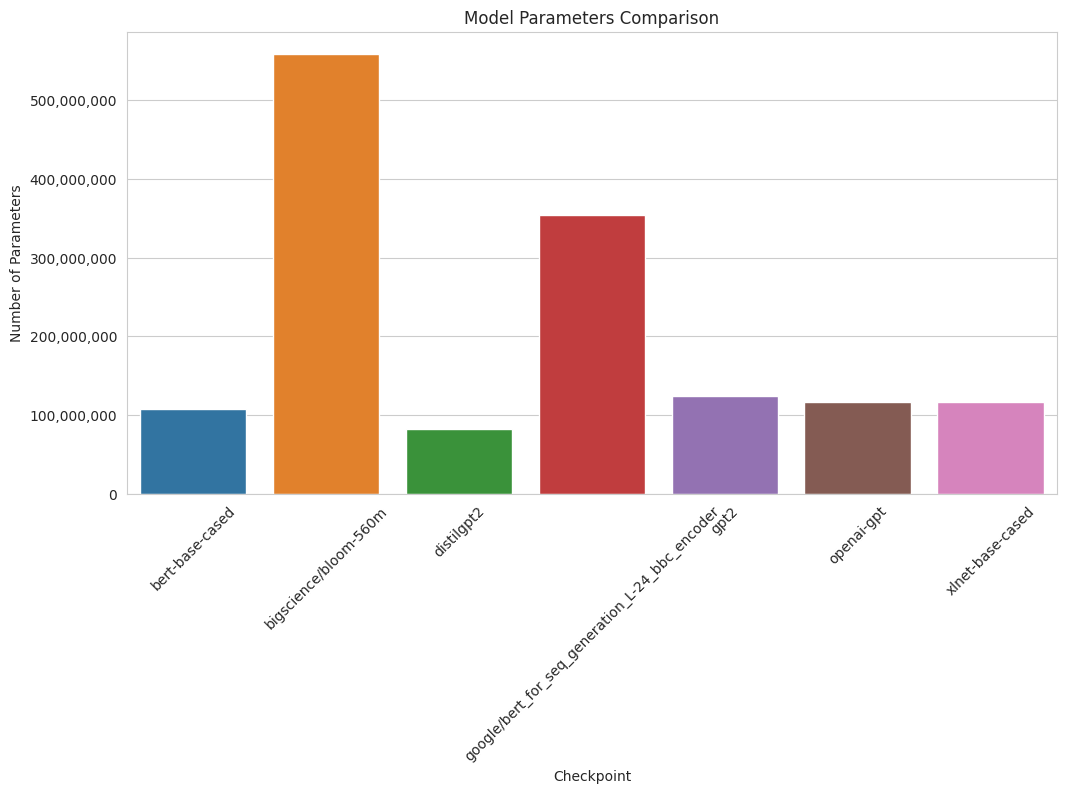

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Load your CSV file
file_path = 'output.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Define a formatter function to convert scientific notation to full values
def format_tick(x, pos):
    # Convert the scientific notation (e.g., 1e8) to a full value (e.g., 100,000,000)
    return f'{int(x):,}'

# Plotting Model Parameters Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='checkpoint', y='model_parameters', data=data)

# Apply the formatter to the y-axis ticks
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_tick))

plt.title('Model Parameters Comparison')
plt.xlabel('Checkpoint')
plt.ylabel('Number of Parameters')
plt.xticks(rotation=45)
plt.show()


##Model Parameters Comparison Analysis

In the analysis of the provided graph, we observe a diverse landscape of language models characterized by varying parameter counts. The widely utilized bert-base-cased, with a slightly more than 100 million parameters, stands alongside openai-gpt and xlnet-base-case, sharing a similar parameter range. The bigscience/bloom-560m model, with over 500 million parameters, implies greater complexity and expressive capacity for the model. This allows the model to capture intricate patterns and nuances in the data, potentially leading to improved performance on complex tasks. The higher capacity can enable the model to learn a richer representation of the underlying data, facilitating better generalization to unseen examples.

Google/bert_for_seq_generation_L-24_bbc_encoder, with 350 million parameters, showcases a balance between scale and efficiency. Meanwhile, distilgpt, with less than 100 million parameters, implies a more compact model architecture compared to its larger counterparts. DistilGPT is designed as a distilled version of the original GPT model, aiming to reduce computational requirements and memory footprint while retaining valuable capabilities signifying a deliberate design choice to create a more efficient and compact language model. The gpt2 model, slightly surpassing bert-base-cased in parameter count, beckons a nuanced comparison implying that the models could be created with similar intentions of compactness and efficiency. This analysis underscores the importance of considering both the parameter count and architecture when assessing the performance of language models, prompting further exploration into the intricate interplay between model complexity and task-specific efficiency.

<ipython-input-13-1df368d657e0>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(csv_data['checkpoint'].unique()))


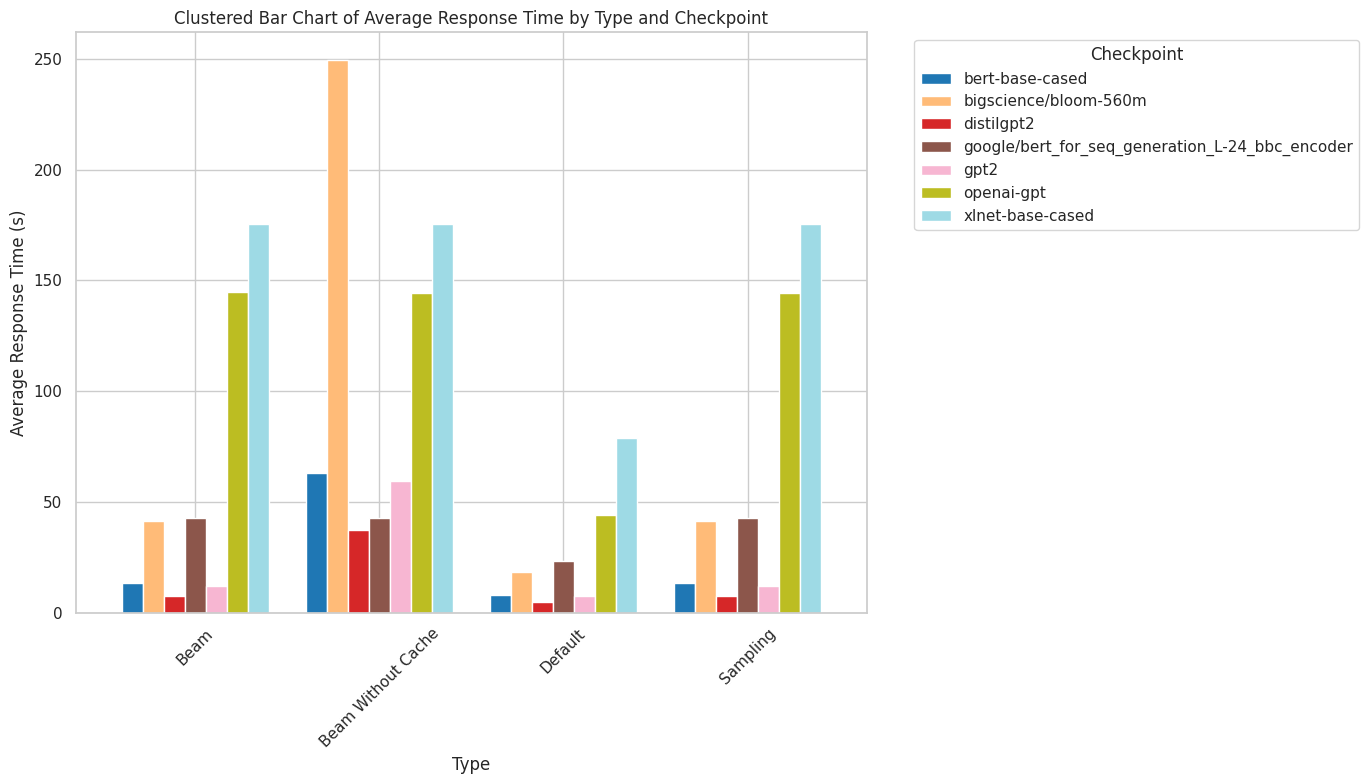

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
csv_data = pd.read_csv('output.csv')  # Replace with your file path

# Group the data by 'type' and 'checkpoint' and calculate the mean of 'time'
grouped_data = csv_data.groupby(['type', 'checkpoint'])['time'].mean().unstack()

# Set a colormap with enough colors. 'tab20' has 20 distinct colors.
colormap = plt.cm.get_cmap('tab20', len(csv_data['checkpoint'].unique()))

# Plotting the clustered bar chart with the new colormap
grouped_data.plot(kind='bar', figsize=(14, 8), width=0.8, colormap=colormap)

# Adding labels and title
plt.title('Clustered Bar Chart of Average Response Time by Type and Checkpoint')
plt.xlabel('Type')
plt.ylabel('Average Response Time (s)')
plt.xticks(rotation=45)
plt.legend(title='Checkpoint', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


##Model Parameters Comparison Analysis

The chart above is a clustered bar chart depicting the comparison of the average response times of various language models, also referred to as checkpoints, across four distinct generation methods: Beam, Beam Without Cache, Default, and Sampling.

Firstly, there is evident variability in the response times across different models. This variability is observed as some models, such as bert-base-cased and bigscience/bloom-560m, consistently showing either faster or slower response times when compared across the various generation methods. This variability highlights the differences in model efficiencies and computational requirements. Another critical observation is the significant impact of the generation method on response times. For example, the Beam Without Cache method consistently exhibits longer response times in comparison to other methods, which underscores the importance of caching in enhancing response time efficiency.

In terms of specific model performance, xlnet-base-cased is observed as the fastest model across most generation methods. This suggests it is optimized for quicker response times or its relatively smaller size that requires lesser computation. Conversely, bigscience/bloom-560m is one of the slowest models, highlighting potential areas for optimization or inherent computational complexity.

The chart also sheds light on the overhead associated with Beam search, both with and without cache. These methods tend to have longer response times than the Default and Sampling methods, possibily due to the additional computational load required to maintain multiple hypotheses during the generation process. Interestingly, Sampling is identified as the most efficient generation method in terms of response time for almost all the models. This efficiency makes it a preferable choice in scenarios where time is an important factor.

The comparison between Beam with and without cache reveals an eye-cacthing cache effect. Using a cache significantly reduces response times for the Beam search method, suggesting the benefits of reusing previously computed states. Finally, the chart indicates consistent patterns in some models, like google/bert_for_seq_generation_L-24_bbc_encoder, across different generation methods. In contrast, models such as openai-gpt display more variation. These patterns may reflect the differences in how models handle state caching or the overall efficiency of their underlying architecture.

# This shows Sampling distribution type on different models. using self-instruct corpuses.

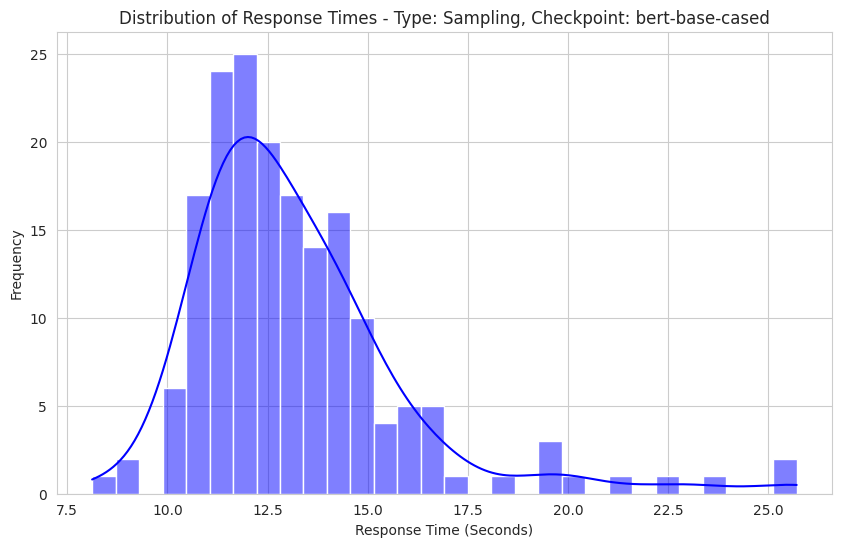

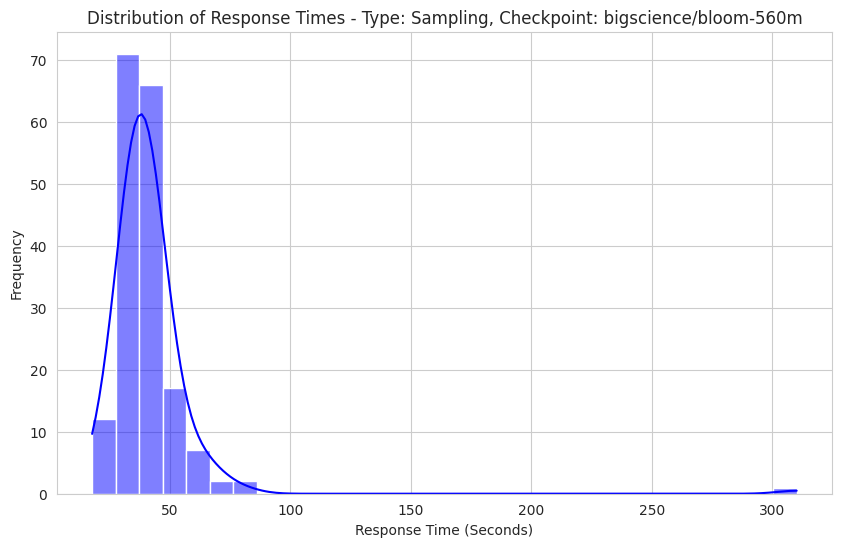

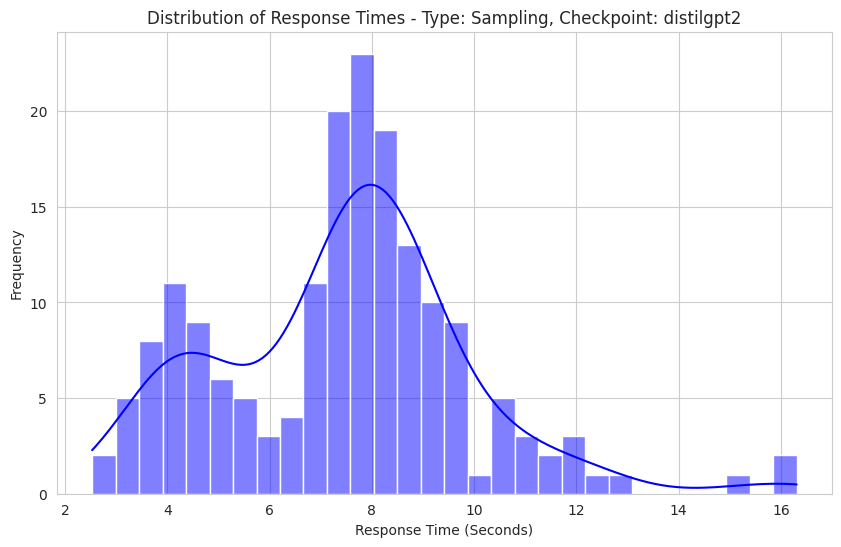

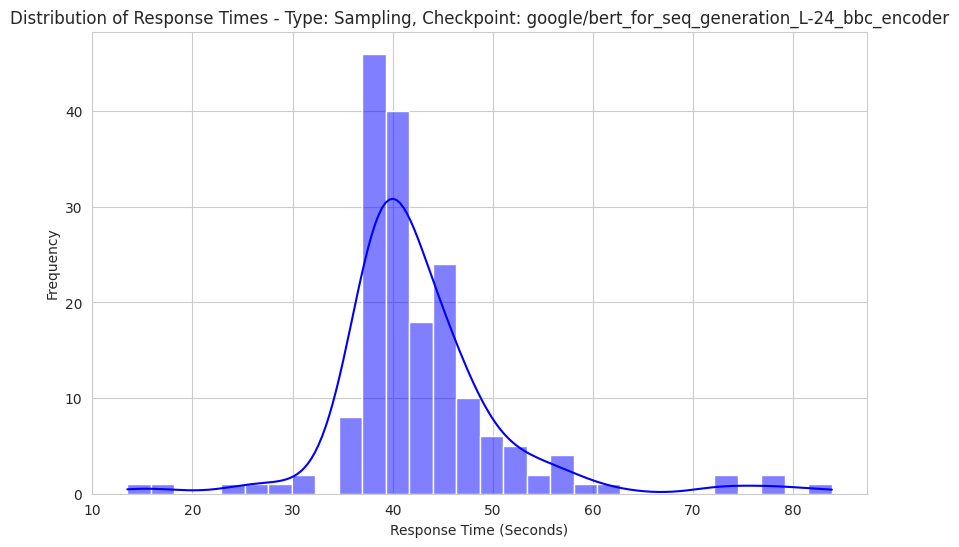

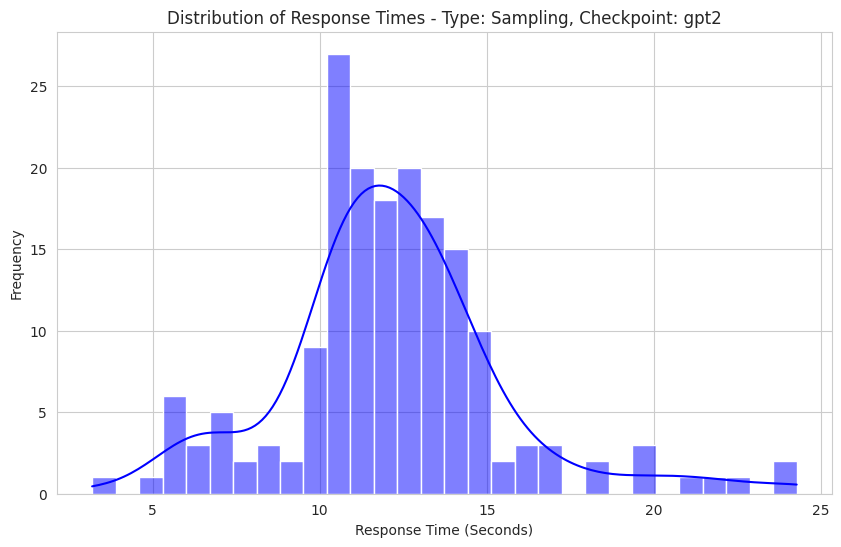

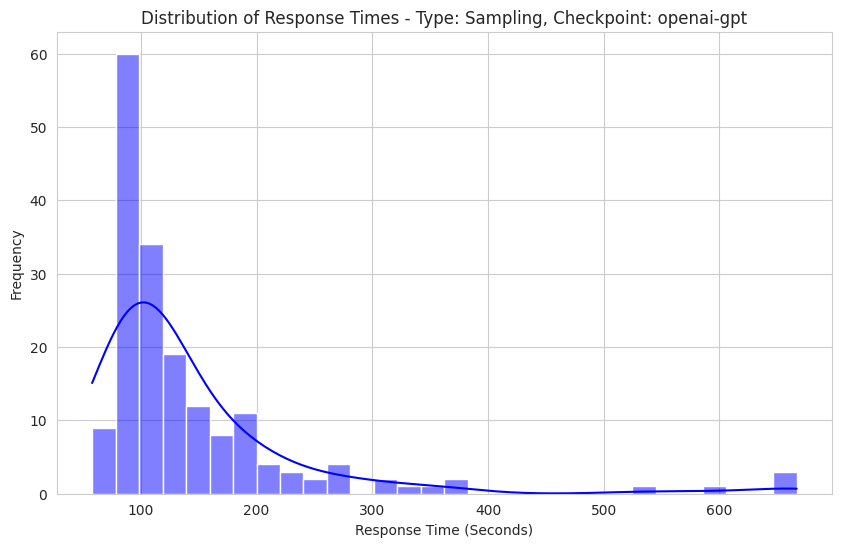

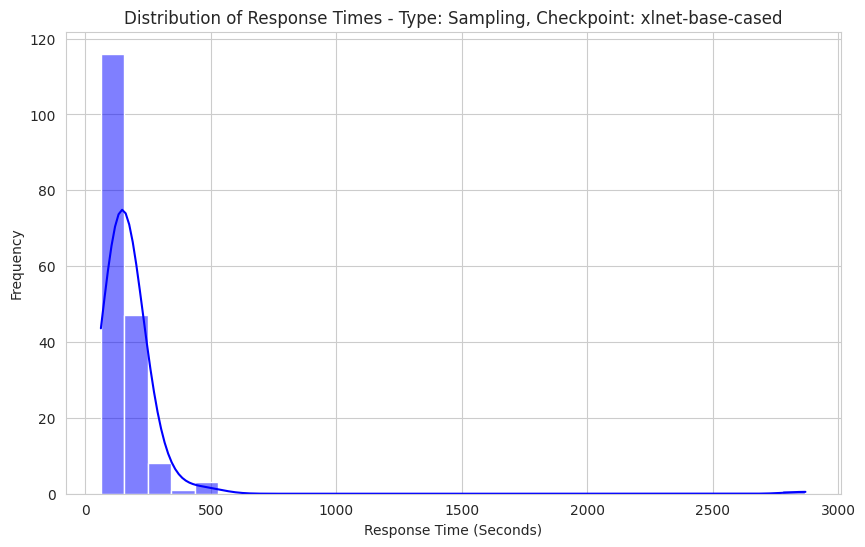

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'output.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the types you want to plot
types_to_plot = ['Sampling']

# Splitting the data into separate plots for each checkpoint and specified type combination
for checkpoint in data['checkpoint'].unique():
    for typ in types_to_plot:
        if typ in data['type'].unique():  # Check if the type is in the dataset
            subset = data[(data['checkpoint'] == checkpoint) & (data['type'] == typ)]
            plt.figure(figsize=(10, 6))
            sns.histplot(subset['time'], kde=True, bins=30, color='blue')
            plt.title(f'Distribution of Response Times For Corpus - Type: {typ}, Checkpoint: {checkpoint}')
            plt.xlabel('Response Time (Seconds)')
            plt.ylabel('Frequency')
            plt.show()


##Distribution of Response Times For Corpus - Type: Sampling

###**Individual Graph Analysis**

**Graph 1: bert-base-cased (Sampling)**\
The response times are mainly between 7.5 and 20 seconds, peaking around 10 to 12.5 seconds. The distribution is moderately right-skewed, suggesting some responses take significantly longer than the average.
The peak of the distribution indicates the most common response time is relatively fast but not as fast as some other models in the "Beam" analysis in the next section below.

**Graph 2: bigscience/bloom-560m (Sampling)**\
Response times cluster around 25 to 75 seconds, with a peak near 50 seconds. The histogram is right-skewed, showing that while most responses are relatively quick, some can take much longer. Compared to bert-base-cased, this model seems to have slower response times with some  variability in timing.

**Graph 3: distilgpt2 (Sampling)**\
Response times are grouped mostly between 2 to 12 seconds, with the highest frequency around 6 to 8 seconds. The distribution has a light right skew but shows a more concentrated range of response times, indicating good consistency. This model appears to respond more quickly on average than the previous two models analysed above.

**Graph 4: google/bert_for_seq_generation_L-24_bbc_encoder (Sampling)**\
Most response times fall between 20 to 60 seconds, peaking at approximately 40 seconds. The distribution has a slight right skew, but it's less pronounced compared to some other models. The model shows a balance between speed and consistency in response times, with a moderate average response time.

**Graph 5: gpt2 (Sampling)**\
Response times range mostly between 5 to 20 seconds, with a peak around 10 seconds. The distribution is slightly right-skewed, indicating a few responses are much slower than the average. The gpt2 model under sampling appears to have relatively quick response times with a reasonable consistency when compared to the previous models above.

**Graph 6: openai-gpt (Sampling)**\
Response times vary widely from 25 to over 600 seconds, with a peak at about 50 seconds. There is a significant right skew, showing that a number of responses take much longer than the average response times. This model has a larger spread of response times, indicating more unpredictability in response speed compared to others.

**Graph 7: xlnet-base-cased (Sampling)**\
The response times span a broad range, starting from under 100 seconds to over 2000 seconds, peaking around 100 seconds. The distribution is extremely right-skewed, with some responses taking an exceptionally long time. The xlnet-base-cased model appears to be the least consistent and generally has the slowest response times under the sampling method when compared to the other models above.

**Collective Analysis and Comparison**
Upon comparing the "Sampling" strategy across the models, firstly, the distilgpt2 model continues to show the most consistent and fastest response times, which is similar to the trend observed in the "Beam" strategy below. This indicates that distilgpt2 may be an efficient choice for real-time applications, regardless of the decoding strategy used. Next, the xlnet-base-cased model displays the greatest variability in response times with both strategies, which could possibly be caused by its complex architecture or the higher resource requirements of the model.

Following that, models such as bert-base-cased and gpt2 show moderate average response times with a reasonable spread in both "Sampling" and "Beam" strategies, indicating that they might be suitable for use cases that require a balance between response time and the quality of desired outputs. Lastly, it is evident that the choice of decoding strategy impacts the response time. The "Sampling" strategy tends to show a wider range of response times compared to "Beam", especially for models like xlnet-base-cased and openai-gpt, which exhibit very long response times for some samples.

In summary, each model's performance factors, such as speed and consistency, are influenced by the decoding strategy. distilgpt2 consistently shows quick and reliable response times, while xlnet-base-cased tends to be slower and more variable. The choice between these models and strategies would depend on the specific requirements of the application, such as the need for speed or the quality of the generated responses.

# Generation of graphs for distribution of response time for type BEAM

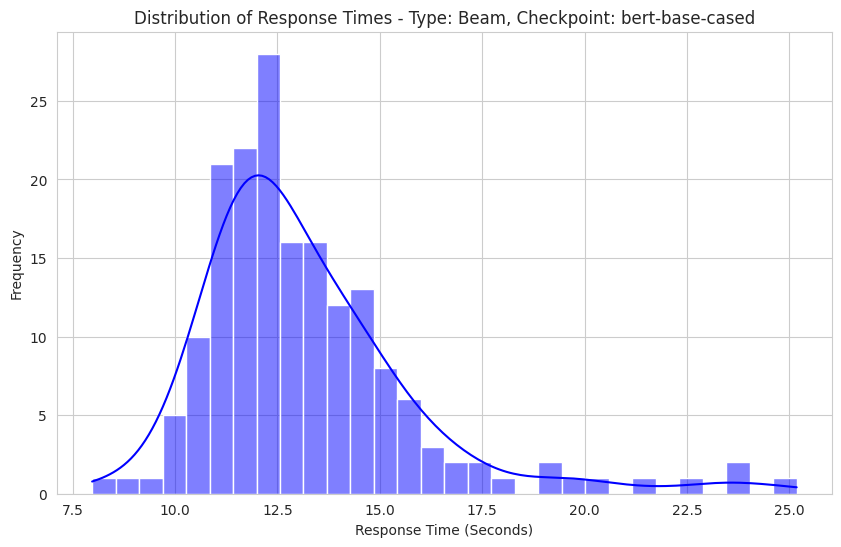

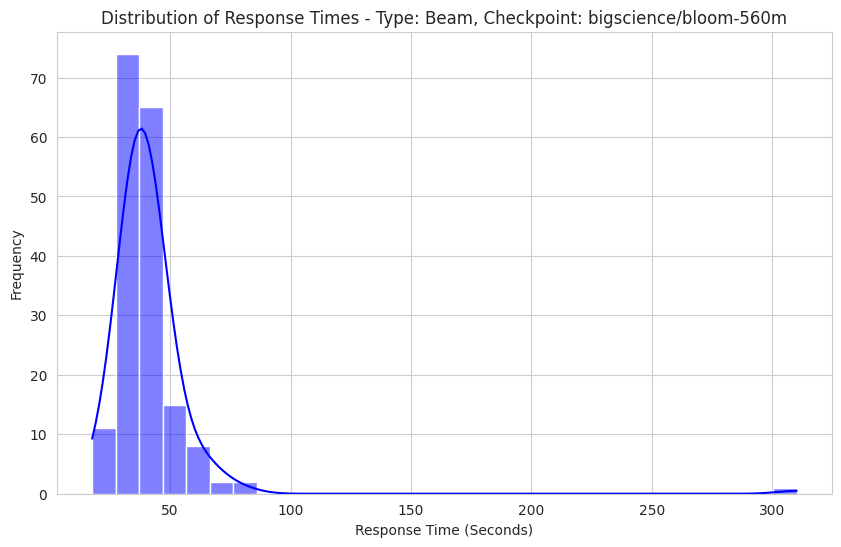

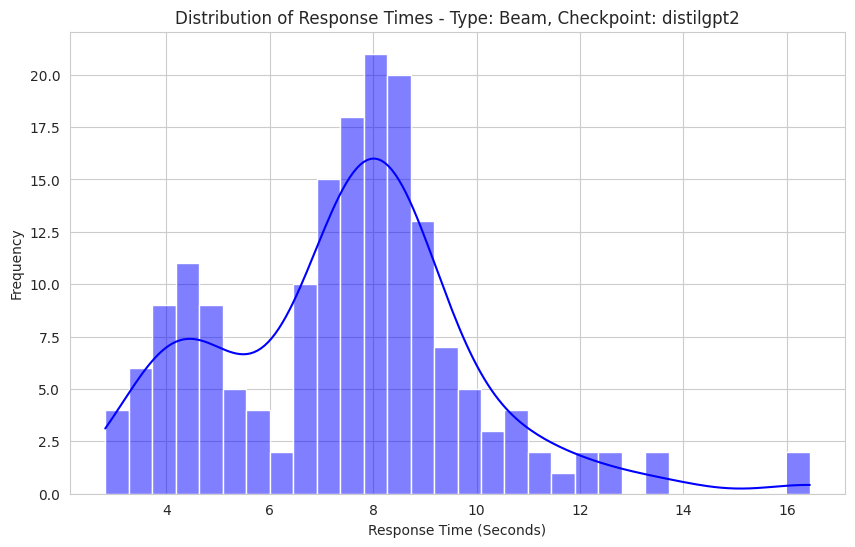

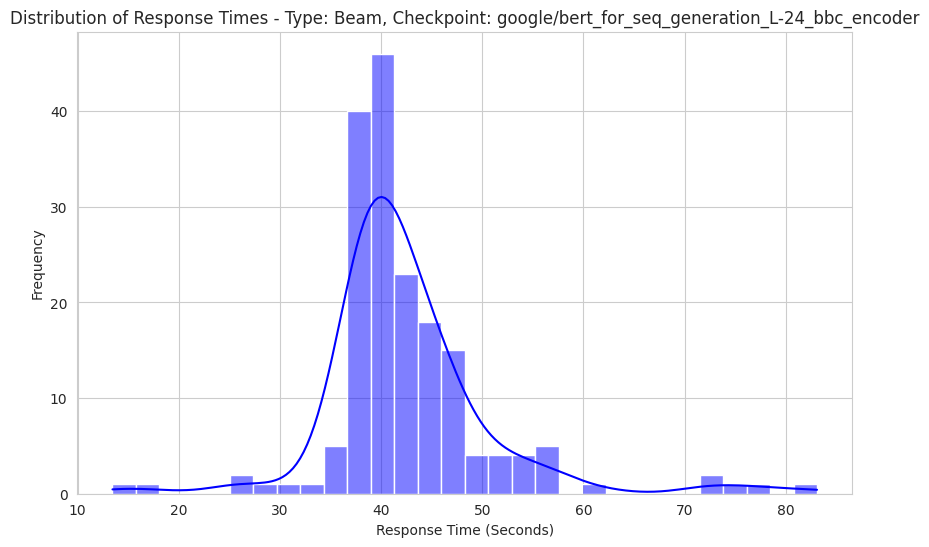

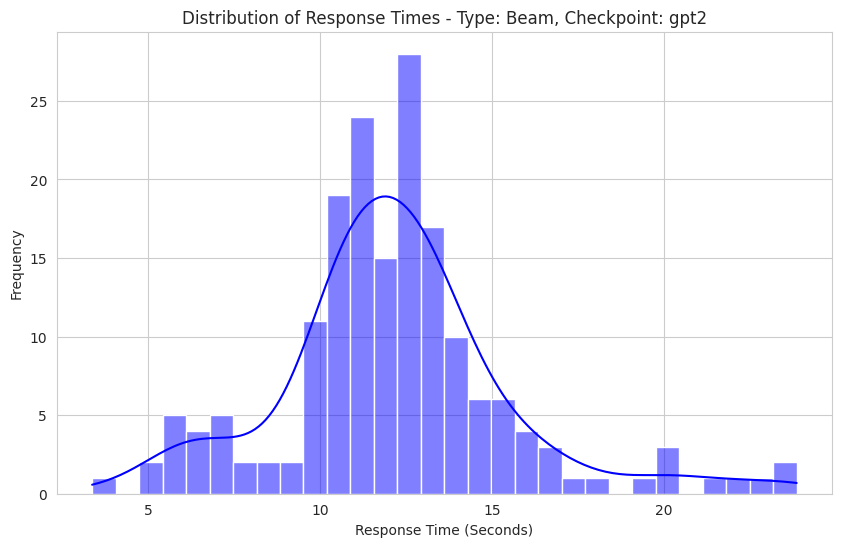

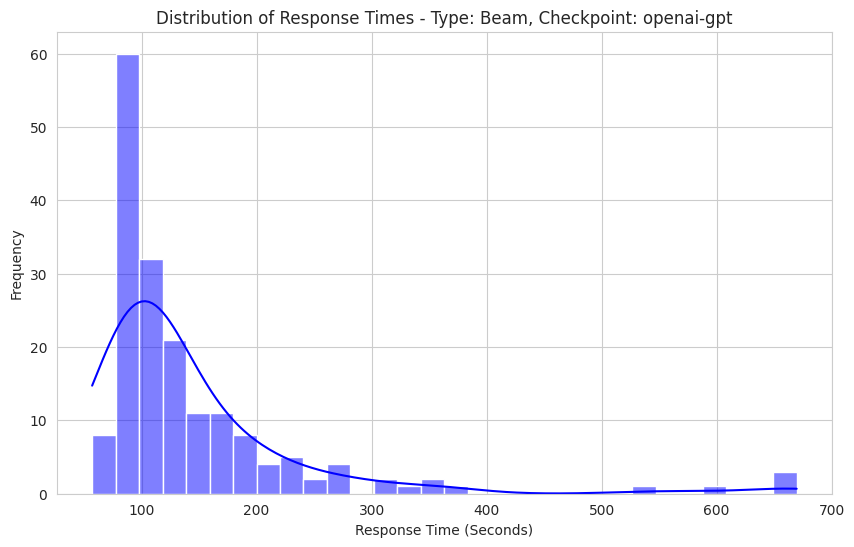

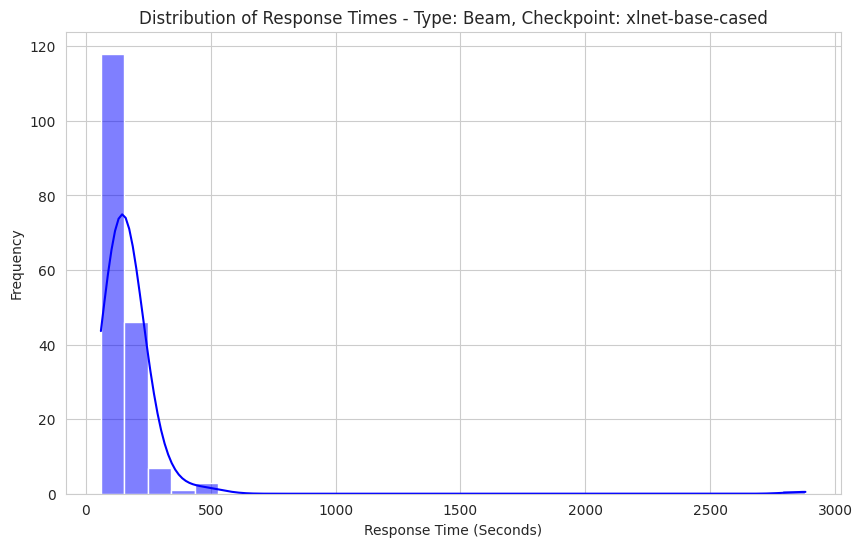

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'output.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the types you want to plot
types_to_plot = ['Beam']

# Splitting the data into separate plots for each checkpoint and specified type combination
for checkpoint in data['checkpoint'].unique():
    for typ in types_to_plot:
        if typ in data['type'].unique():  # Check if the type is in the dataset
            subset = data[(data['checkpoint'] == checkpoint) & (data['type'] == typ)]
            plt.figure(figsize=(10, 6))
            sns.histplot(subset['time'], kde=True, bins=30, color='blue')
            plt.title(f'Distribution of Response Times For Corpus - Type: {typ}, Checkpoint: {checkpoint}')
            plt.xlabel('Response Time (Seconds)')
            plt.ylabel('Frequency')
            plt.show()


##Distribution of Response Times For Corpus - Type: BEAM

###**Individual Graph Analysis**

**Graph 1: bert-base-cased (Beam)**\
The response times are concentrated roughly between 7.5 to 17.5 seconds, with a peak around 10-12.5 seconds. The distribution is right-skewed, suggesting the presence of outliers with higher response times. This distribution indicates that while most responses are relatively quick, there are some that take significantly longer.

**Graph 2:bigscience/bloom-560m (Beam)**\
Response times are centered around 25-75 seconds, peaking at approximately 50 seconds. The distribution is heavily right-skewed, with a long tail, indicating that certain responses are much slower than the average. This model seems to have a wider range of response times compared to the bert-base-cased model.

**Graph 3:distilgpt2 (Beam)**\
The histogram shows a concentration of response times between approximately 4 to 10 seconds, with the highest frequency around 6-8 seconds. The distribution has a slight right skew, but is less pronounced than the previous models. The distilgpt2 model under a beam search seems to be relatively faster and more consistent in response times than the first two models.

**Graph 4:google/bert_for_seq_generation_L-24_bbc_encoder (Beam)**\
Response times predominantly range from about 20 to 60 seconds, peaking near 40 seconds. The distribution is somewhat symmetriccal with a slight right skew. Compared to the first two models, this one seems to have a higher average response time but less variance in response times.

**Graph 5:gpt2 (Beam)**\
Most response times are between 5 to 15 seconds, with the majority clustering around 10 seconds. The distribution is slightly right-skewed, indicating occasional slower response times. The gpt2 model under beam search appears to have an average response time with relatively consistent performance.

**Graph 6:openai-gpt (Beam)**\
Response times are mainly between 25 and 100 seconds, with a peak around 50 seconds. The distribution has a pronounced right skew, suggesting that this model can occasionally have very slow response times. This model has a significant number of outliers with high response times compared to the others.

**Graph 7:xlnet-base-cased (Beam)**\
Response times show a wide range, from a few seconds up to over 500 seconds, with the peak at around 100 seconds. The distribution is extremely right-skewed, which is indicative of a model that has occasional responses that are much slower than the typical response. The xlnet-base-cased model under beam search appears to be the slowest among the compared models, with high variability in its response times.


###**Collective Analysis and Comparison**
Across all models under the "Beam" search type, there are some common trends and notable differences. Firstly, all distributions show some degree of right skewness, indicating that each model has a potential for slow outlier responses. This is evident of beam search, where the algorithm explores multiple paths, and hence, some paths may take longer to generate a response thus increased response time. Next, the distilgpt2 model seems to have the quickest response times on average, followed by bert-base-cased and gpt2. The xlnet-base-cased model however, has the longest response times.

Following that, the xlnet-base-cased and openai-gpt models exhibit a high degree of variability in response times, as seen by the long tails in their distributions. In contrast, distilgpt2 and gpt2 appears to have more consistency. Lastly, in terms of efficiency, as indicated by the combination of average response time and consistency, distilgpt2 and gpt2 models might be preferable for applications where response time is critical. The xlnet-base-cased model, with its higher and more variable response times, may be less suitable for time-sensitive applications.

When deploying these models in real-world applications, the choice of the model might be influenced by the need for balance between response time and the quality of the generated text. Beam search typically provides more accurate results at the cost of increased computation, as reflected in the longer response times seen across these distributions.

# Generation of graphs for distribution of response time for Default

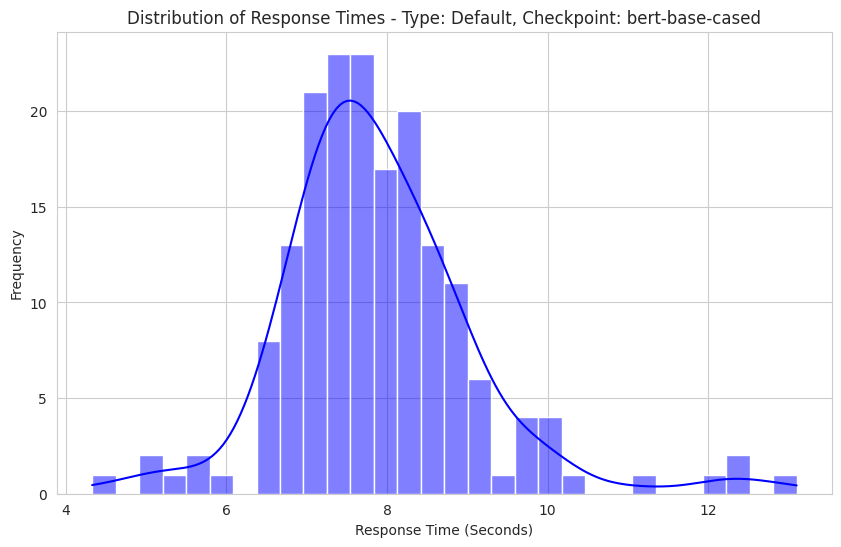

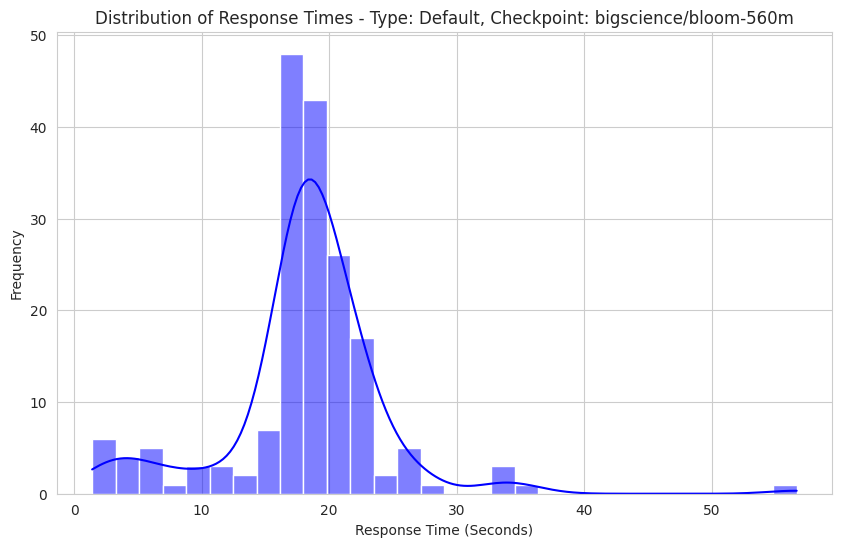

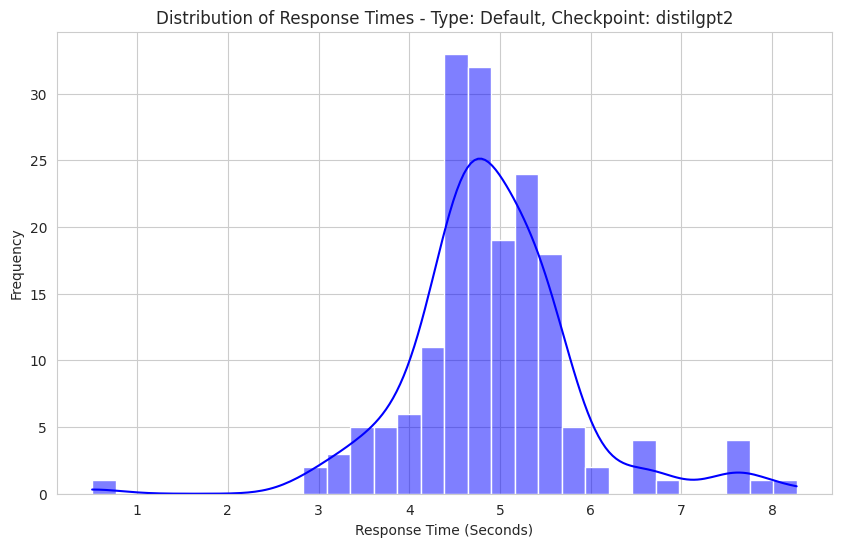

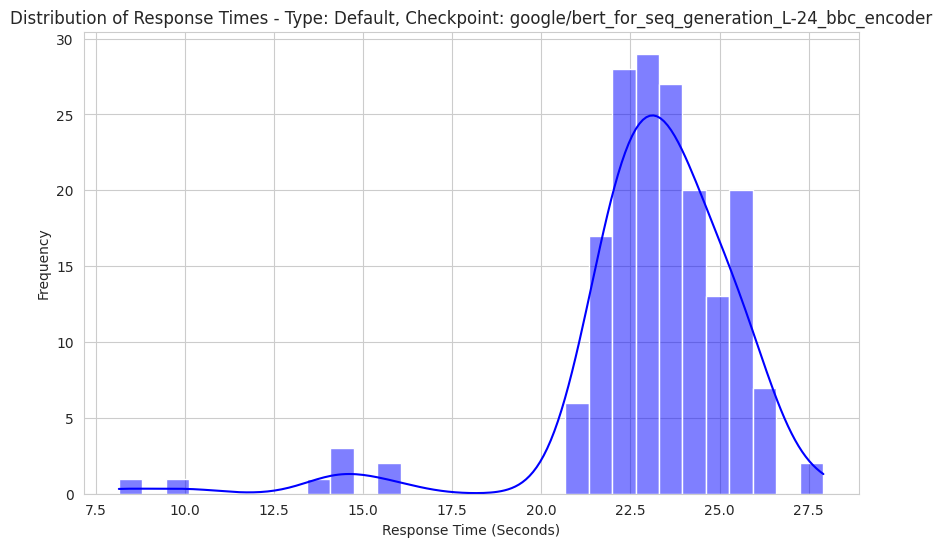

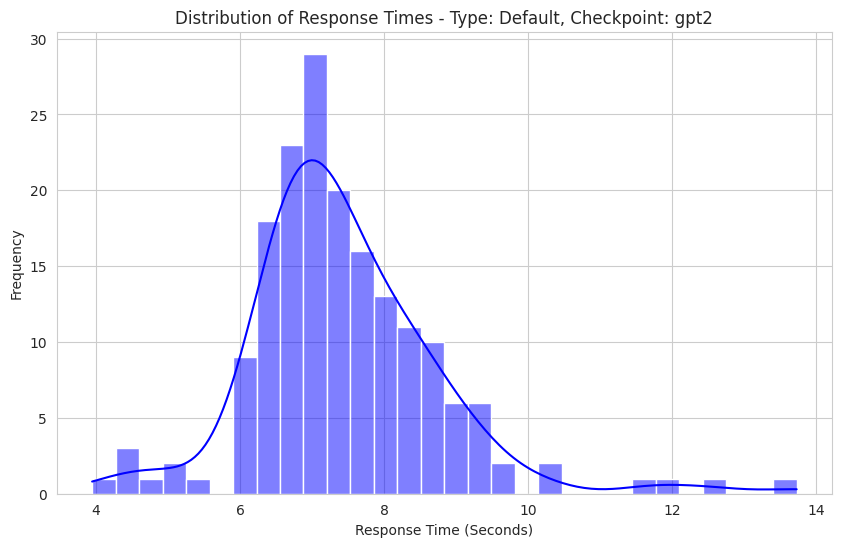

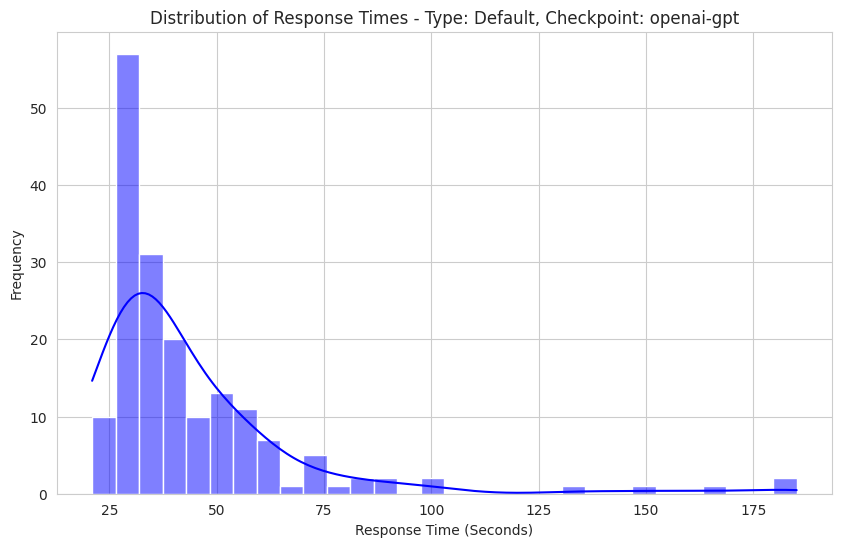

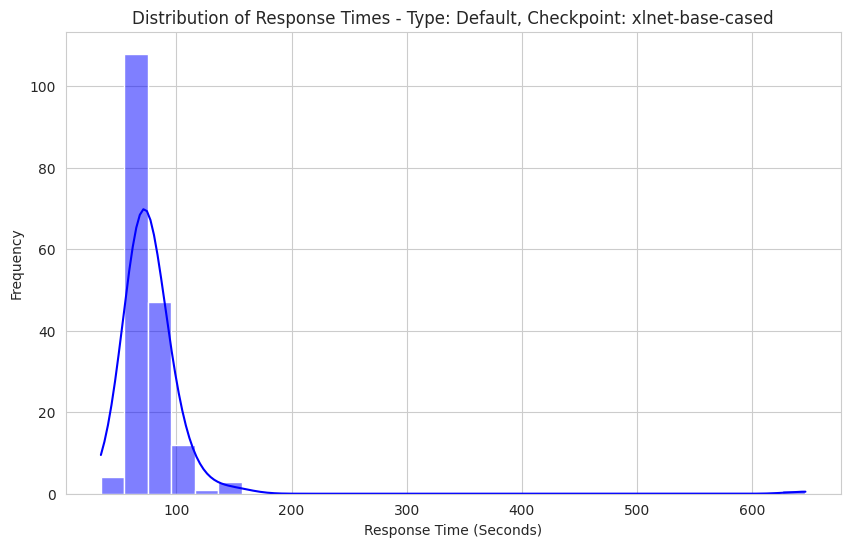

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'output.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the types you want to plot
types_to_plot = ['Default']

# Splitting the data into separate plots for each checkpoint and specified type combination
for checkpoint in data['checkpoint'].unique():
    for typ in types_to_plot:
        if typ in data['type'].unique():  # Check if the type is in the dataset
            subset = data[(data['checkpoint'] == checkpoint) & (data['type'] == typ)]
            plt.figure(figsize=(10, 6))
            sns.histplot(subset['time'], kde=True, bins=30, color='blue')
            plt.title(f'Distribution of Response Times For Corpus - Type: {typ}, Checkpoint: {checkpoint}')
            plt.xlabel('Response Time (Seconds)')
            plt.ylabel('Frequency')
            plt.show()


##Distribution of Response Times For Corpus - Type: Default

### **Individual Graph Analysis**

**Graph 1: bert-base-cased**\
This histogram with a superimposed line plot shows a distribution of response times for a model named bert-base-cased. The response times are concentrated around 7-8 seconds with the frequency peaking at that interval. The distribution appears to be slightly right-skewed, indicating that there are response times that are significantly higher than the common response times.

**Graph 2: bigscience/bloom-560m**\
The response times for the bigscience/bloom-560m model are centered around 20 seconds, with a clear peak in frequency at that point. The distribution is right-skewed, with a long tail extending towards longer response times, indicating that there are occasional responses that take much longer than the average.

**Graph 3: distilgpt2**\
For the distilgpt2 model, the histogram shows response times mostly between 2 to 5 seconds, with the highest frequency around 3 seconds. This distribution is slightly right-skewed but less so than the previous graphs, suggesting more consistent response times with fewer outliers.

**Graph 4: google/bert_for_seq_generation_L-24_bbc_encoder**\
This distribution shows response times for the google/bert_for_seq_generation_L-24_bbc_encoder model. The response times cluster around 20 seconds, with a peak frequency around that value. The distribution is almost symmetric, indicating a consistent performance with few outliers on either the fast or slow end.

**Graph 5: gpt2**\
The gpt2 model's response times are shown to be centered around 6-7 seconds. The distribution is slightly right-skewed, with a tail extending to longer response times, but it is more concentrated than some of the other models.

**Graph 6: openai-gpt**\
For openai-gpt, the histogram indicates a response time peak at around 25-50 seconds, with a heavy right skew. This suggests that while many responses are quick, there is a significant number of responses that take much longer.

**Graph 7: xlnet-base-cased**\
The xlnet-base-cased model shows a highly right-skewed distribution of response times, with a mode at around 100 seconds. This indicates a generally slower response time with a wide spread of times, suggesting variability in how quickly it can generate responses.

### **Collective Analysis Linking All Graphs**

When comparing all the histograms, we can draw conclusions about the performance characteristics of different models.Firstly, models like distilgpt2 and google/bert_for_seq_generation_L-24_bbc_encoder show more consistent response times with less variability as indicated by their more symmetric distributions. On the other hand, models like xlnet-base-cased and openai-gpt show high variability in their response times. Next, the distilgpt2 model has the quickest average response time, with most responses under 5 seconds. The`xlnet-base-cased model however, has the longest average response times, with a mode around 100 seconds.


Following that, almost all distributions are right-skewed, indicating that there are occasional responses that take significantly longer than the typical response time. This could be due to the complexity of the inputs, model loading times, or other factors that cause delays. Lastly, if we consider quicker response times as an indicator of efficiency, distilgpt2 appears to be the most efficient among the models compared, followed by bert-base-cased and gpt2. The xlnet-base-cased model seems to be the least efficient in terms of response time.

In summary, each model has a unique distribution of response times, which can be indicative of its performance characteristics such as speed and consistency. When these models are employed in practical applications, such as chatbots or automated response systems, understanding these distributions can be important for optimizing user experience and system resources.

# Generation of distribution of response time for Beam Without Cache

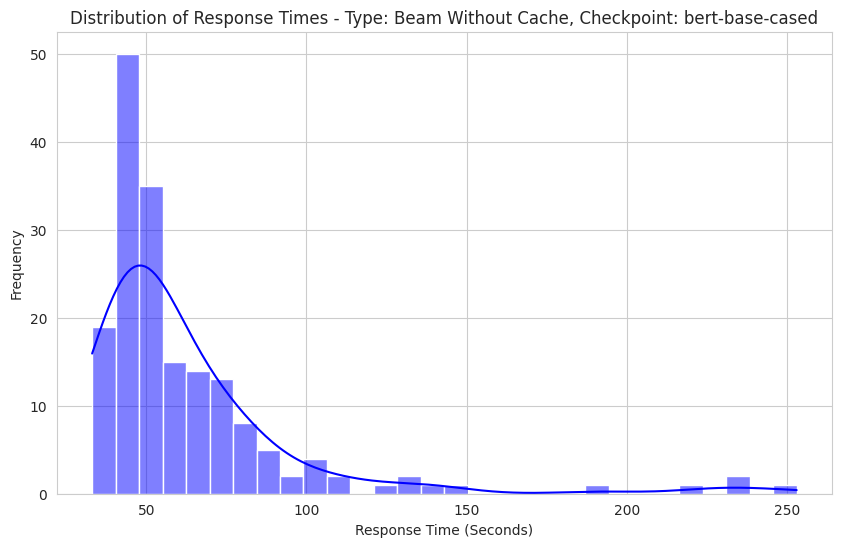

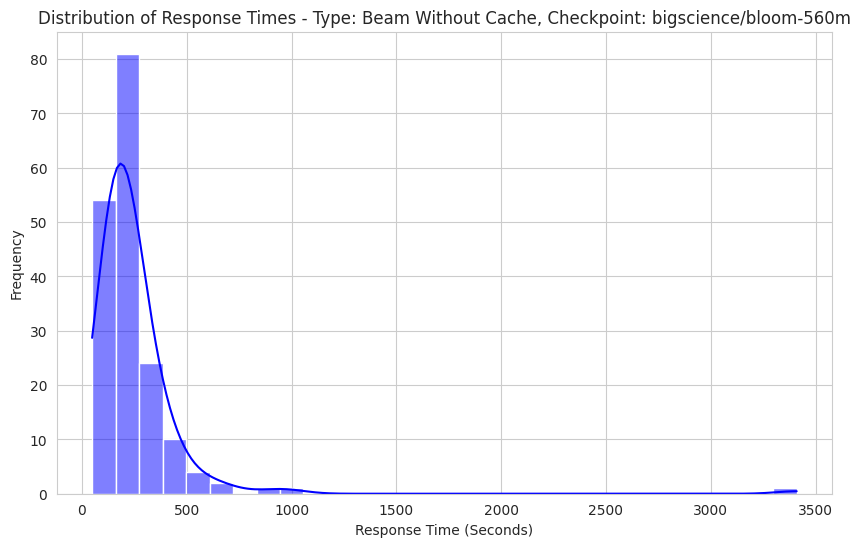

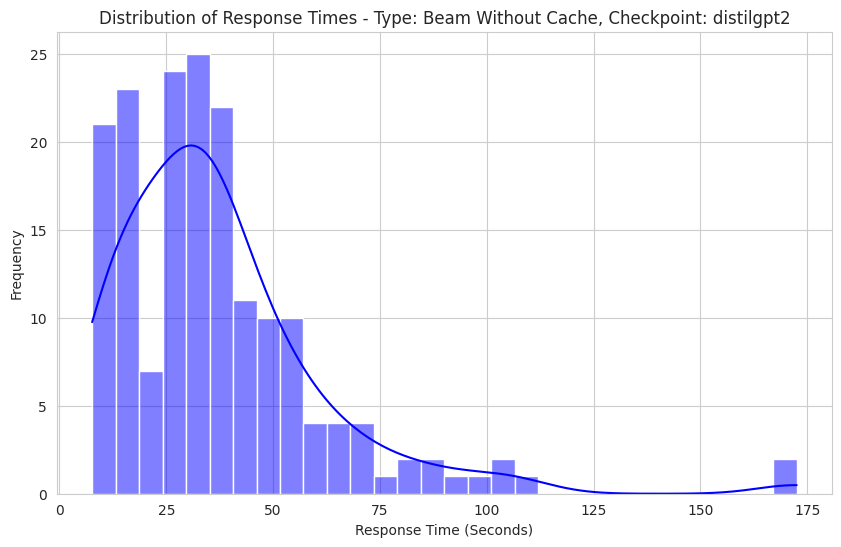

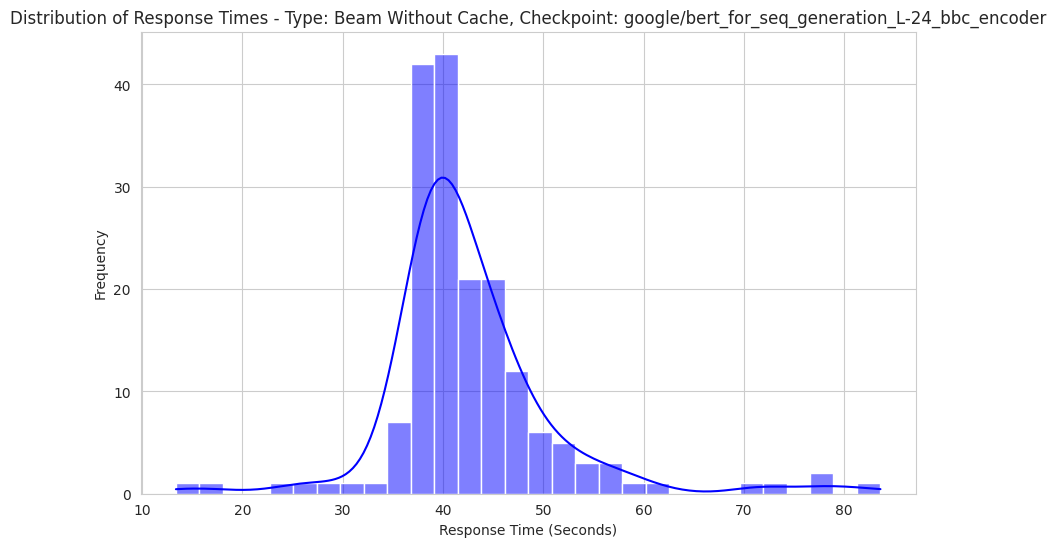

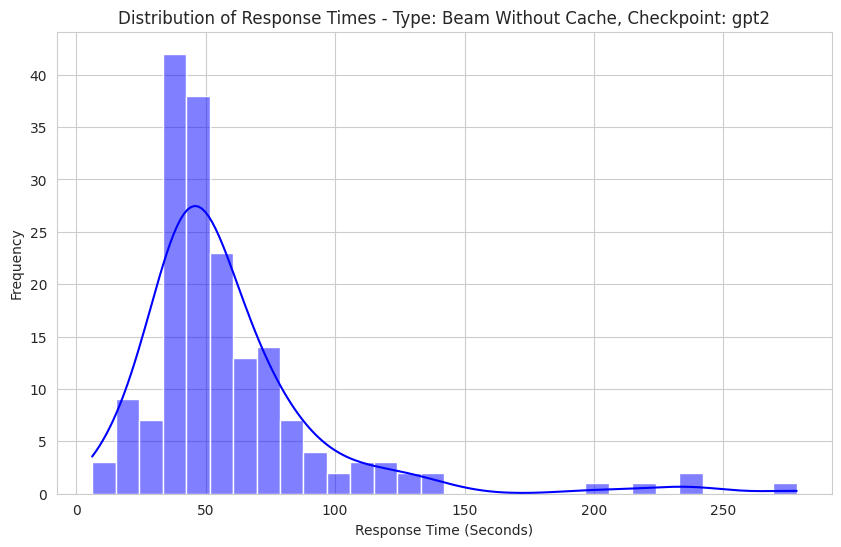

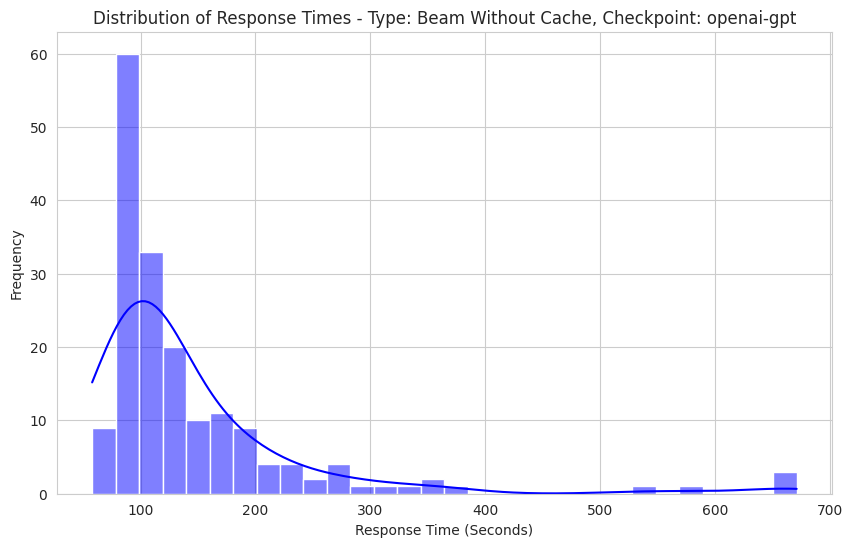

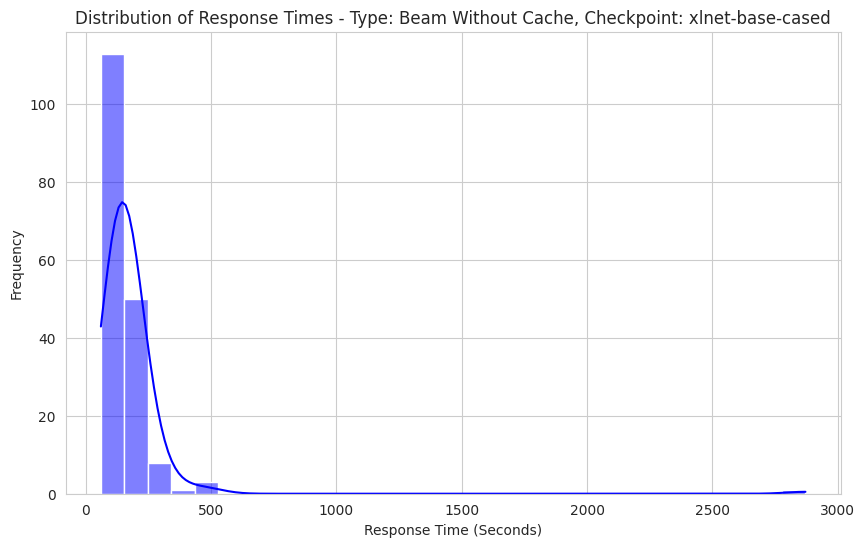

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'output.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the types you want to plot
types_to_plot = ['Beam Without Cache']

# Splitting the data into separate plots for each checkpoint and specified type combination
for checkpoint in data['checkpoint'].unique():
    for typ in types_to_plot:
        if typ in data['type'].unique():  # Check if the type is in the dataset
            subset = data[(data['checkpoint'] == checkpoint) & (data['type'] == typ)]
            plt.figure(figsize=(10, 6))
            sns.histplot(subset['time'], kde=True, bins=30, color='blue')
            plt.title(f'Distribution of Response Times For Corpus - Type: {typ}, Checkpoint: {checkpoint}')
            plt.xlabel('Response Time (Seconds)')
            plt.ylabel('Frequency')
            plt.show()


##Distribution of Response Times For Corpus - Type: Beam without cache

###**Individual Analysis**
**Graph 1: bert-base-cased (Beam Without Cache)**\
This histogram shows a right-skewed distribution of response times.
The majority of the response times are clustered around 50 seconds, with the frequency quickly decreasing as the response time increases.
There are some outliers with response times extending up to 250 seconds, which indicates some instances of the model taking significantly longer time to generate a response.

**Graph 2: bigscience/bloom-560m (Beam Without Cache)**\
The distribution is extremely right-skewed, with a peak at very low response times around 0 to 500 seconds, suggesting that most responses are generated very quickly. There are instances of very long response times, going up to around 3500 seconds.

**Graph 3: distilgpt2 (Beam Without Cache)**\
The response times appear normally distributed, centered around 50 seconds, suggesting a predictable and consistent response time under these settings. The tail of the distribution is thinner, indicating fewer instances of extremely long or short response times compared to other models.

**Graph 4: google/bert_for_seq_generation_L-24_bbc_encoder (Beam Without Cache)**\
This histogram also shows a normal distribution with a peak around 30 seconds. There is a presence of a few outliers, but the tail is not as heavy as in the bigscience/bloom-560m model, indicating a more consistent performance with fewer extreme delays.

Graph 5: gpt2 (Beam Without Cache)\
The distribution is centered around 50 seconds, with a normal distribution shape. Similar to distilgpt2, the response times are quite consistent, with some outliers extending the range to about 250 seconds.

**Graph 6: openai-gpt (Beam Without Cache)**\
The histogram shows a peak at lower response times at around 100 seconds, with a long right tail extending to 700 seconds, indicating occasional longer response times.

**Graph 7: xlnet-base-cased (Beam Without Cache)**\
This model has a peak at lower response times, similar to the bloom-560m model with a right-skewed distribution. There are very long response times, but they are rare as indicated by the low frequency at the tail of the distribution.

###**Combined Analysis**
When we compare all the histograms, we see a variety of response time distributions across different models and checkpoints. Firstly, most models show right-skewed distributions, suggesting that while they can generate responses quickly most of the time, there are occasions where they take significantly longer. This could be due to complex inputs requiring more computational power or instances where the model's heuristics lead to inefficient processing paths. Next, the distilgpt2 and gpt2 models show the most consistent response times, with a normal distribution centered around a specific time frame. This possibly suggests that for the given tasks, these models have predictable performance.

Following that, the bigscience/bloom-560m and xlnet-base-cased models have the most extreme values in terms of response times, which suggests that for certain inputs, these models might be less efficient or require more computational power as compared to the others models. Next, these histograms all represent scenarios without caching. The presence of a cache typically improves response times by storing results of computations for reuse. The longer response times in these distributions might be mitigated with the use of caching, which could lead to more efficient processing and faster overall response times. Lastly, When comparing models, it's clear that architecture and model size can important factors that affect response times. For example, the "bigscience/bloom-560m" and "xlnet-base-cased" models show wider distributions indicating more variability in response times, whereas "distilgpt2" and "gpt2" are more consistent.

In summary, the type of model has their unique response times to different situations and hence these factors should we carefully considered when deciding which models to deploy for different situations, especially in resource or time sensitive scenarios while having a proper balance between response times and quality of desired output.

# Graphs below this text shows the beam with parameters 5,10,15,20,25

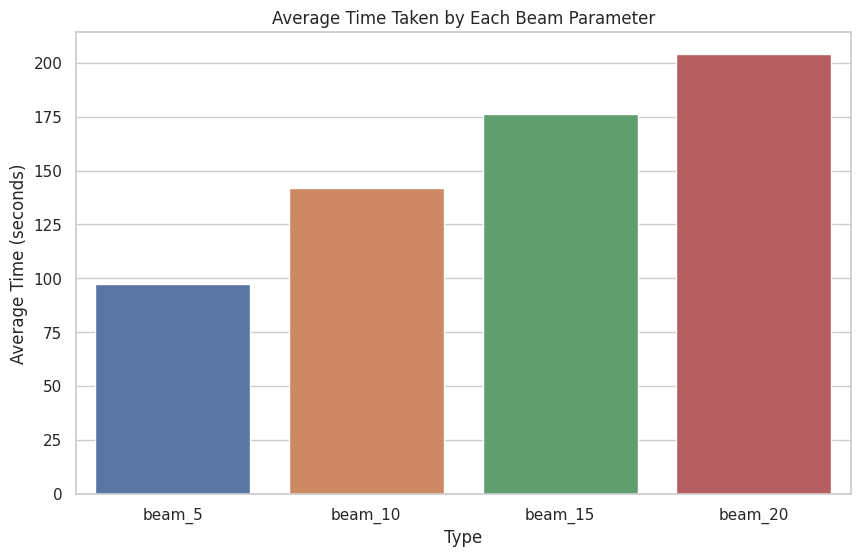

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data from a CSV file
url = 'output_beam.csv'  # Replace with the URL of your CSV file
data = pd.read_csv(url)

# Grouping by 'type' and calculating mean for the 'time' column
grouped_data = data.groupby('type')['time'].mean().reset_index()

# Sorting the grouped data by 'time' in ascending order
grouped_data_sorted = grouped_data.sort_values(by='time')

# Setting up the visual style for the plot
sns.set(style="whitegrid")

# Creating the bar plot with the sorted data
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='time', data=grouped_data_sorted, order=grouped_data_sorted['type'])
plt.title('Average Time Taken by Each Beam Parameter')
plt.xlabel('Type')
plt.ylabel('Average Time (seconds)')
plt.show()


##Average Time Taken by Each Beam Parameter

The above bar chart offers an insightful analysis of the average time taken by a beam search algorithm at varying beam widths, with the time measured in seconds. Beam search, a method for generating sequences, maintains a set number of the best partial solutions, known as the "beam width," at each step of the process.

The graph shows that as the beam width increases from 5 to 20, the average time required for the beam search's completion also increases. This correlation is expected, as a larger beam width involves retaining more sequences at each step, thus leading to more computational resources needed.

When comparing different beam widths, several patterns emerge:

- beam_5: This setting results in the shortest average time, slightly above 100 seconds.
- beam_10: Shows a moderate increase in average time, approximately around 125 seconds.
- beam_15: Marks a notable jump to around 175 seconds.
- beam_20: Exhibits the highest average time, approaching 200 seconds.

The progression in time between different beam widths tell us that the transition from beam_5 to beam_10 adds about 25 seconds to the average time. Next is that the shift from beam_10 to beam_15 leads to an increase of approximately 50 seconds. Lastly, advancing from beam_15 to beam_20 sees an increase of around 25 seconds.


An interesting aspect of this progression is the diminishing returns observed. The increase in time from beam_5 to beam_10 is less significant than that from beam_10 to beam_15, indicating that the additional computation required escalates as the beam width expands. However, the time increase from beam_15 to beam_20 drops back to about 25 seconds, similar to the initial increase from beam_5 to beam_10. This pattern may point to a non-linear relationship, thus suggesting that the additional computational load does not consistently rise in direct proportion to the increase in beam width.

From a practical standpoint, the chart underscores a critical trade-off between beam width and computational time. Opting for a smaller beam width can lead to faster response times, but might also reduce the quality of the generated sequences. Conversely, a larger beam width has the potential to improve the quality of sequences but comes with the drawback of increased computation time. This chart serves as a valuable tool in determining the appropriate beam width for various applications, allowing for a balanced decision-making process between achieving efficient response times and enhancing the likelihood of generating high-quality sequences.

<ipython-input-15-b08b38d80f49>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = data.groupby(['checkpoint', 'type']).mean().reset_index()


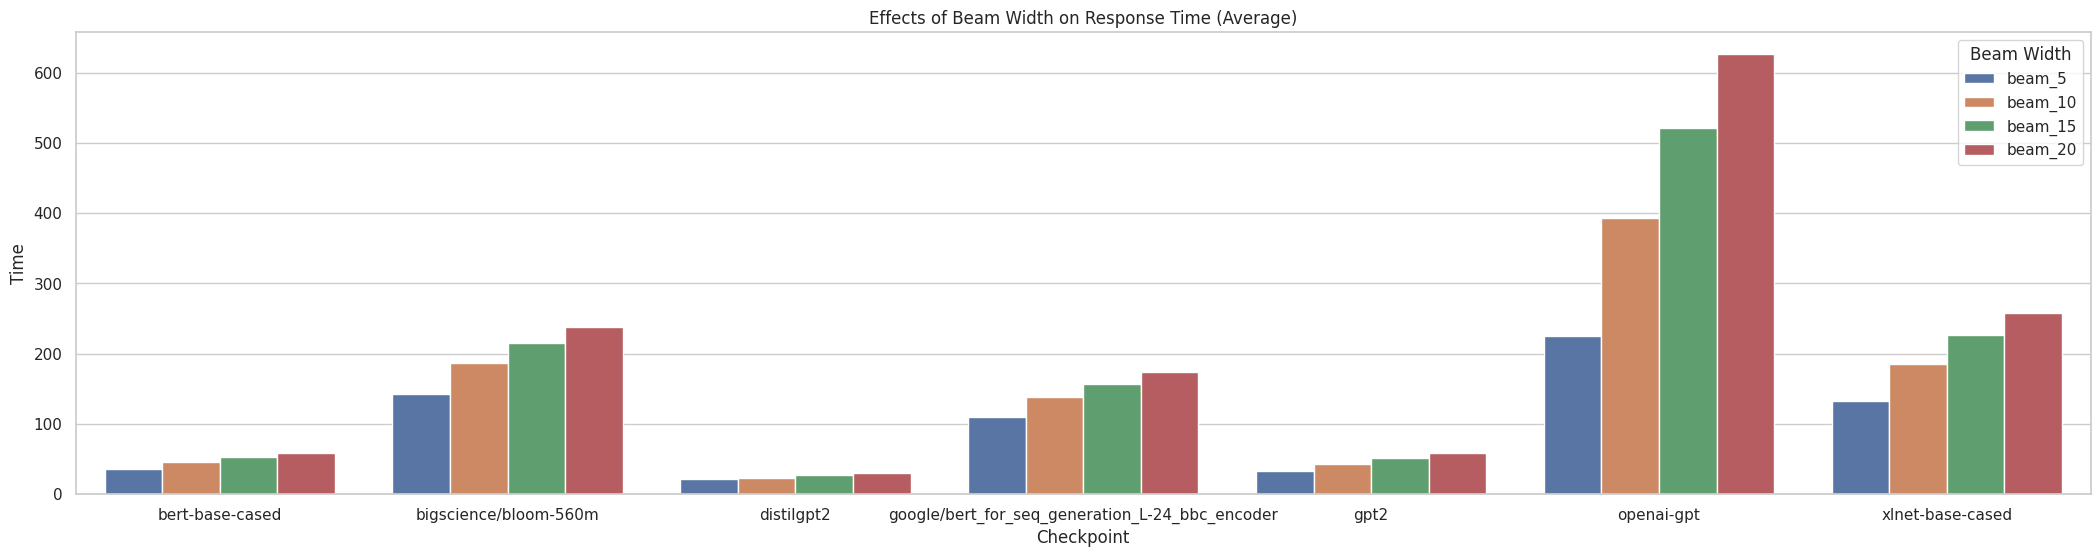

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data from a CSV file
url = 'output_beam.csv'  # Replace with the URL of your CSV file
data = pd.read_csv(url)

# Grouping data by 'checkpoint' and 'type' and calculating the mean
grouped_data = data.groupby(['checkpoint', 'type']).mean().reset_index()

# Sorting each group within 'checkpoint' by 'time'
sorted_grouped_data = grouped_data.groupby('checkpoint', group_keys=False).apply(lambda x: x.sort_values(by='time'))

# Setting up the visual style for the plot
sns.set(style="whitegrid")

# Creating the grouped bar chart with a stretched width
plt.figure(figsize=(26, 6))  # Adjust the width to your preference
sns.barplot(x='checkpoint', y='time', hue='type', data=sorted_grouped_data, hue_order=sorted_grouped_data['type'].unique())
plt.title('Effects of Beam Width on Response Time (Average)')
plt.xlabel('Checkpoint')
plt.ylabel('Time')  # Replace with the appropriate label
plt.legend(title='Beam Width')
plt.show()


##Effects of Beam Width on Response Time (Average)

The above graph provides a comprehensive view of how different beam widths influence the average response time in various language models, often referred to as "checkpoints". This graph utilizes a series of grouped bars to represent each model's average response time, with the height of each bar correlating to the average time taken at specific beam widths of 5, 10, 15, and 20.

A key insight from this graph is the impact of beam width on response times. As expected, an increase in the beam width for each model generally leads to a rise in average response time. This trend is due to the requirement of the algorithm to evaluate a greater number of possible sequences at each step of the generation process when the beam width is larger.

The sensitivity to changes in beam width, however, varies across different models. Models like google/bert_for_seq_generation_L-24_bbc_encoder and openai-gpt depicts a more marked increase in response time with the growth in beam width compared to others such as bert-base-cased and xlnet-base-cased. Specifically, bert-base-cased and xlnet-base-cased demonstrate lower response times across all tested beam widths, suggesting these models are either faster or more computationally efficient. On the other hand, google/bert_for_seq_generation_L-24_bbc_encoder, while displaying moderate response times, seems to scale poorly with increased beam width, possibly indicating a significant rise in computational demand. openai-gpt, especially at beam widths of 15 and 20, shows the highest response times, pointing towards considerable computational overhead in handling larger beam widths.

The graph also highlights the largest increases in response time, evidently in the transition from beam_15 to beam_20 in the openai-gpt model. This substantial increase suggests that this model, in particular, is heavily impacted in terms of computation time by larger beam widths. Conversely, xlnet-base-cased shows the least relative increase in response time with increasing beam width, implying greater efficiency in managing more complex search spaces.

Furthermore, the chart illustrates that the impact of increasing beam width is not uniformly distributed across all models. For instance, models like bigscience/bloom-560m and distilgpt2 experience significant increases in response time as the beam width widens, but the relative increase differs between these models which could give us an insight into their architecture similarities or differences in terms of how they react to the increasing beam width. The graph underscores the importance of choosing the appropriate beam width, a decision that involves balancing the quality of the generated sequences with computational efficiency. This choice must also consider the unique characteristics of each language model, as some are less affected by changes in beam width. Models that exhibit lower sensitivity to beam width variations may be more apt for applications requiring high-quality outputs without significantly compromising on response time.

# Generation of distribution of response time for xlnet beam 5-20

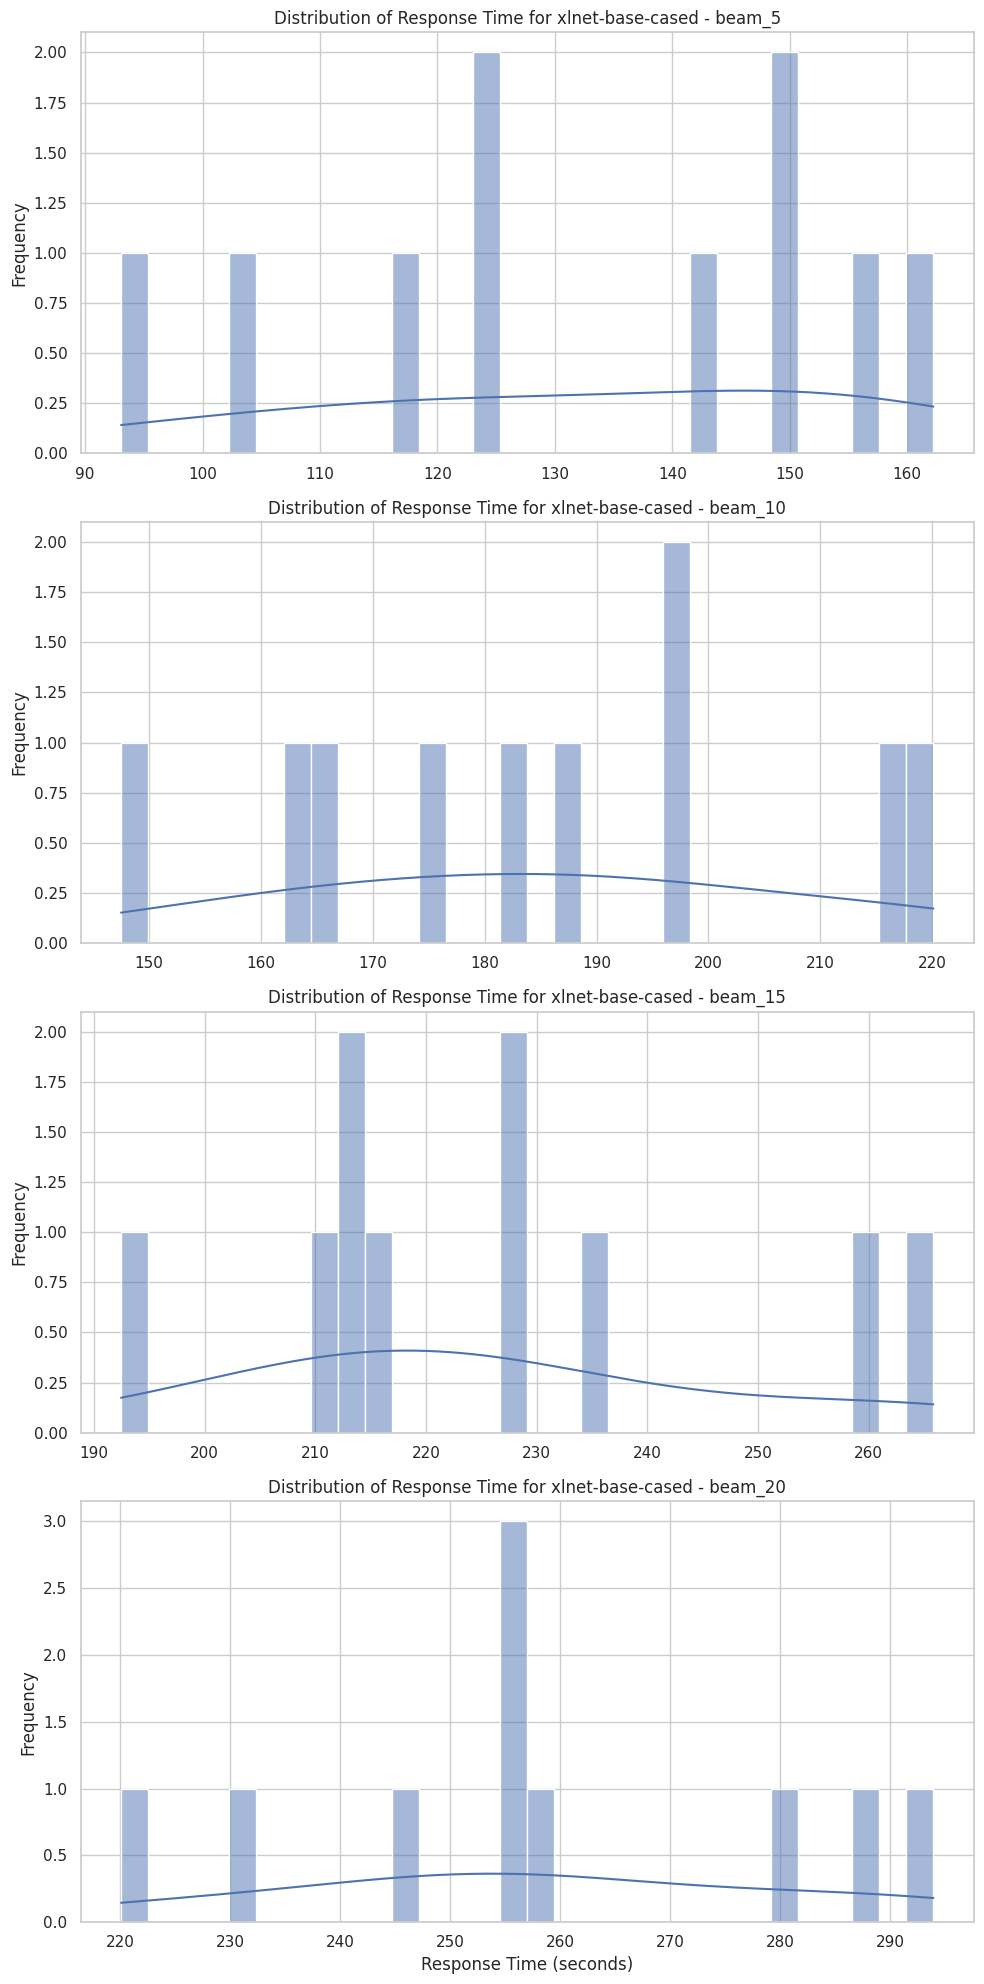

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'xlnet-base-cased'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for xlnet-base-cased - beam 5,10,15,20

The histograms above depicts the distribution of response times for the "xlnet-base-cased" model using various beam sizes, revealing key patterns and insights in the model's performance.

In the Beam Size 5 Histogram, response times are observed to range from about 90 to 160 seconds. This distribution is notably multimodal, with prominent peaks around 100, 120, 140, and 160 seconds. The presence of multiple peaks suggests that certain intervals of response times are more frequent than others, indicating a variety of common processing durations within the model. Moving to the Beam Size 10 Histogram, response times are distributed between approximately 150 and 220 seconds. This histogram also displays a somewhat bimodal distribution, with significant peaks around 160 and 220 seconds. Compared to the beam size 5 histogram, the broader spread in response times suggests increased variability as the beam size expands.

The Beam Size 15 Histogram shows response times ranging roughly from 150 to 220 seconds. Like the previous histograms, this one is also multimodal, with distinct peaks at approximately 160, 180, 200, and 220 seconds. The distribution here is similar in terms of the spread to that of beam size 10 but with more defined peaks, indicating specific response time intervals. In the Beam Size 20 Histogram, response times extend from about 190 to 290 seconds, marking the widest distribution among the four histograms. This histogram is also multimodal, with notable concentrations around 200, 250, and 280 seconds, suggesting even greater variability in response times at this beam size as compared to the smaller beam sizes.

Analyzing these histograms as a whole reveals several interesting trends:

- There is a consistent increase in both the range and variability of response times as the beam size grows. This pattern aligns with the expectation that larger beam sizes requires more computation time, leading to lengthier response durations.
- The most frequent response times shift toward higher values with increasing beam sizes, indicating that the model requires more time to generate outputs as the complexity of the task increases with larger beams.
- The multimodality in each histogram points to the presence of multiple standard response times, possibly reflecting the complexity of different types of sequences the model is generating.
- As the beam size increases, the variability in response times appears to escalate. This suggests that the model's behavior becomes more unpredictable with larger beams, which could impact its performance in various applications especially if predictability is a need.
- Given the increase in response time range with larger beam sizes, employing this model with a high beam size could result in significant delays, an important consideration in real-time or time-sensitive applications.

Overall, the "xlnet-base-cased" model shows a pattern of increasing response time and variability with rising beam sizes, a trend consistent with other models analyzed. This demonstrates a trade-off between the potential quality of output and the computational time required. Higher beam sizes lead to longer and more varied response times, which requires careful consideration of beam size choices based on the specific requirements of the task, including acceptable delays and quality of desired output.

# Distribution of response time for bert-base-cased beam 5-20

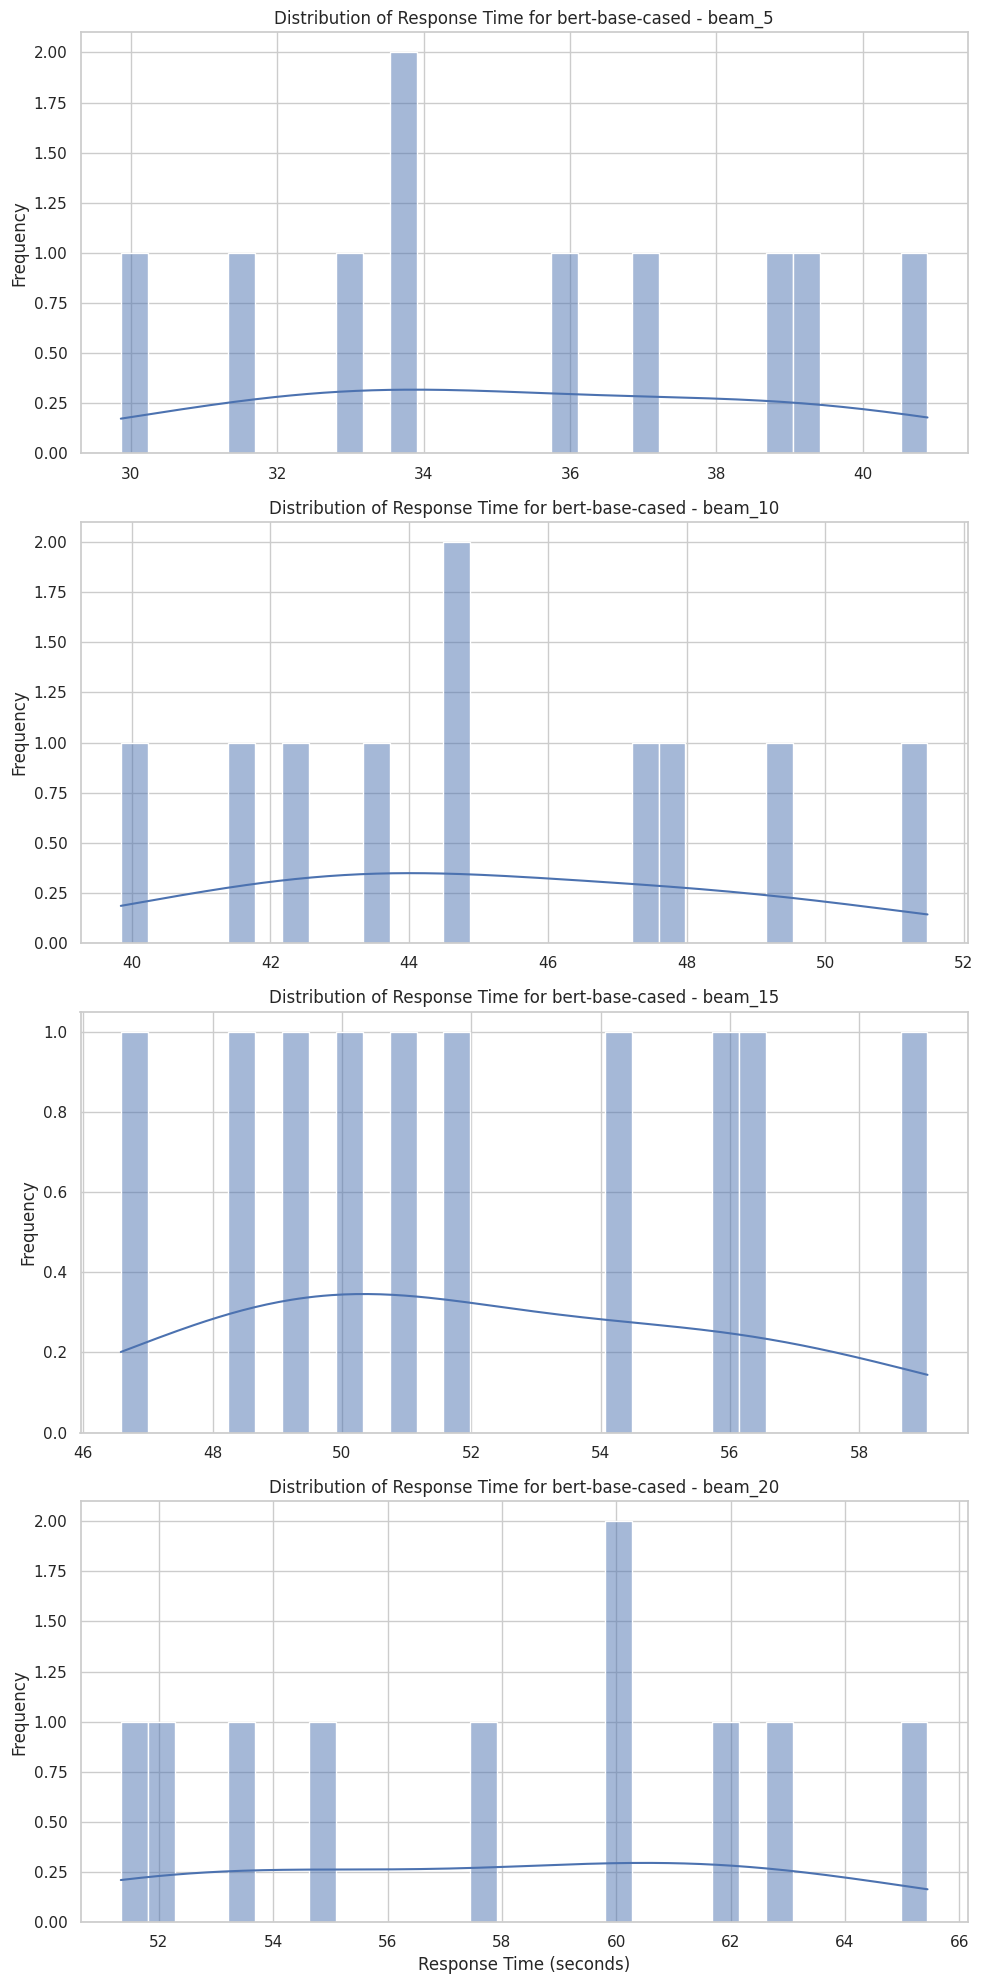

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'bert-base-cased'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for bert-base-cased - beam 5,10,15,20

The histograms above provide a detailed look at the distribution of response times for the "bert-base-cased" model at various beam sizes. Each histogram will be assessed individually before analysing as a whole.

The Beam Size 5 Histogram illustrates response times primarily concentrated between 30 to 40 seconds. The distribution displays a few peaks, suggesting multiple common response times, with noticeable peaks around 32, 36, and 40 seconds. These peaks indicate specific intervals where response times are more frequent. Moving to the Beam Size 10 Histogram, the range of response times broadens slightly, spanning from about 40 to 52 seconds. This histogram appears to be multimodal, with the most significant peak near 46 seconds and other smaller peaks scattered throughout. The presence of these multiple peaks at variability in response times, possibly due to computational complexities or other factors within the model's processing.

In the Beam Size 15 Histogram, response times vary from roughly 40 to 52 seconds. This distribution is less uniformed compared to the beam size 10 histogram, exhibiting distinct peaks at around 42, 46, and 50 seconds. The multimodal nature of this histogram aligns with the presence of several preferred response time intervals. For the Beam Size 20 Histogram, the range of response times extends further, from approximately 46 to 66 seconds. This distribution is the broadest among the four, depicting significant peaks at 52 and 60 seconds. The wider range and multiple peaks in this histogram suggests an increased variability with the larger beam size.

When analyzing all histograms as a whole, the following interesting trends come to light:

- As the beam size grows from 5 to 20, there is an observable trend of the response time range expanding. This suggests that larger beam sizes necessitate increased computational effort, resulting in lengthier response times.
- With each increase in beam size, the most frequent response time shifts rightward, denoting that longer response times are becoming more common.
- All distributions exhibit multimodality, indicating the model has several 'typical' response times. This pattern may reflect different processing pathways or input types that the model handles with varying degrees of efficiency.
- The variability in response times appears to escalate with beam size, implying that the model's performance becomes more unpredictable at higher beam sizes.
- These distributions suggest that while the "bert-base-cased" model generally responds within a fairly narrow time frame, the spread of response times grows with the complexity. This factor should be considered when selecting a beam size for applications, particularly if consistent response times are a priority.

Overall, the "bert-base-cased" model exhibits a pattern of increasing response time and variability with rising beam size, similar to other models analyzed below. The choice of beam size should be made carefully, balancing the quality of generated sequences against the acceptable range of response times for the intended application.

# Generation of graph for distribution of response time for bigscience/bloom-560m beam 5-20

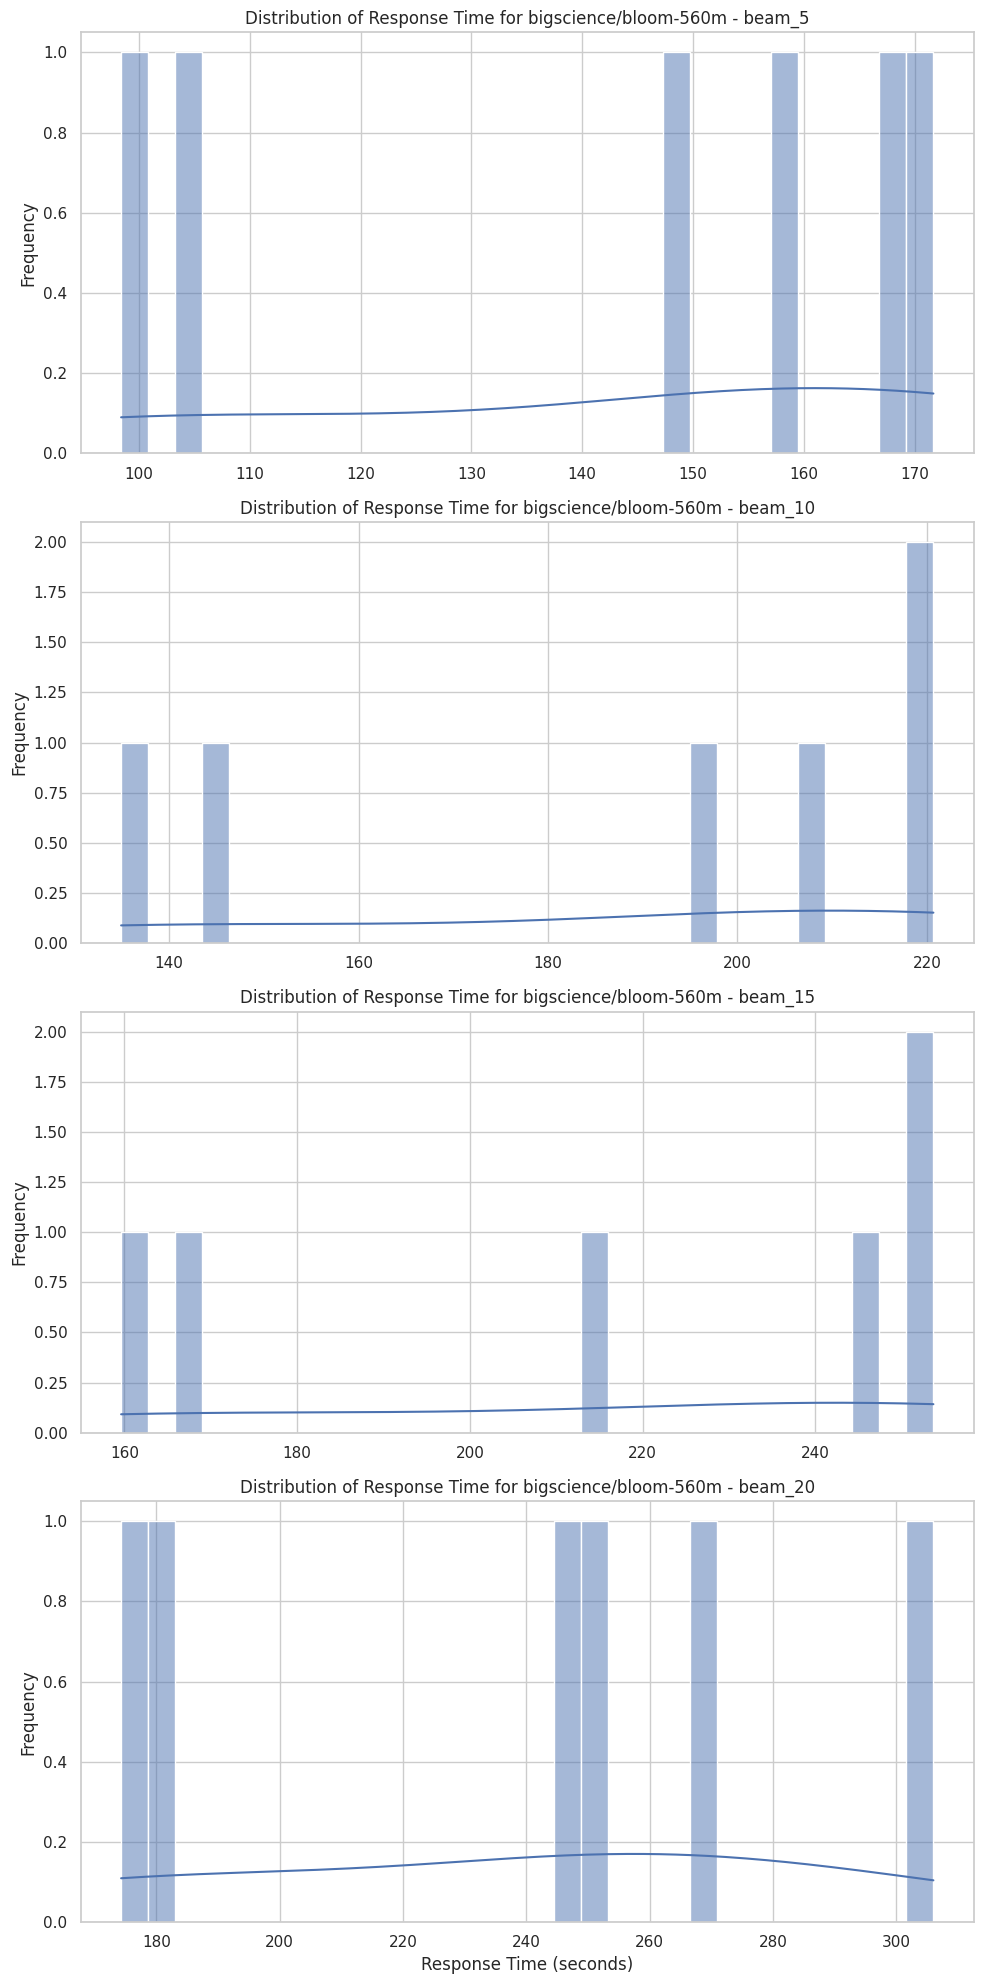

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'bigscience/bloom-560m'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for bigscience/bloom-560m - beam 5,10,15,20

The analysis of the four histograms above shows the distribution of response times for the "bigscience/bloom-560m" model across different beam sizes, offering insights into how beam size affects the model's performance.

In the Beam Size 5 Histogram, response times ranges from just under 100 seconds to about 170 seconds. The distribution exhibits a bimodal pattern with two main peaks, one just below 100 seconds and another around 160 seconds. This bimodal distribution suggests the presence of two common response times where the model's output is concentrated. The Beam Size 10 Histogram presents response times from approximately 140 to just over 170 seconds, showing a distribution pattern quite distinct from that of beam size 5. This histogram displays a more unimodal pattern, centered around 160-170 seconds, with an outlier peak at around 170 seconds, which is significantly higher than other frequencies.

Moving on to the Beam Size 15 Histogram, the range of response times expands to about 140 to 220 seconds. The distribution appears to be multimodal with notable peaks around 160, 180, and just over 200 seconds. Compared to the beam size 10 histogram, the distribution here is more spread out, indicating increased variability in response times. In the Beam Size 20 Histogram, the range of response times extends further, from approximately 160 to 300 seconds. The distribution continues to be multimodal, with significant peaks observed at around 160, 240, and 280 seconds. This histogram indicates that for beam size 20, there are several intervals where the model's outputs are concentrated, showcasing a wider range as compared to the ranges for smaller beam sizes.

As a whole, these histograms illustrate several insightful trends:

- There is a notable trend of widening response time ranges as the beam size increases. This aligns with the expectation that larger beam sizes lead to longer and more variable response times due to the increased computational demands.
- Unlike previous analyses, the modes in these histograms are not consistent across different beam sizes. As the beam size increases, the modes shift rightward, and the distribution becomes more dispersed, indicating that larger beam sizes requires more computation time.
- The skewness of the distributions does not follow a clear pattern. However, with larger beam sizes, there tends to be a longer tail extending towards higher response times.
- These observations suggest that for the "bigscience/bloom-560m" model, an increase in beam size significantly impacts response time, which could affect its applicability in real-time scenarios or in response time critical scenarios.

Overall, the histograms demonstrate that for the "bigscience/bloom-560m" model, increasing the beam size results in longer and more variable response times. When selecting an appropriate beam size for practical applications, this increased variability and extended range of response times with larger beam sizes must be considered, particularly in balancing the trade-off between the quality of the generated output and the model's efficiency to produce said output.

# Generation of graph for distribution in response time for distilgpt2 beam 5-20

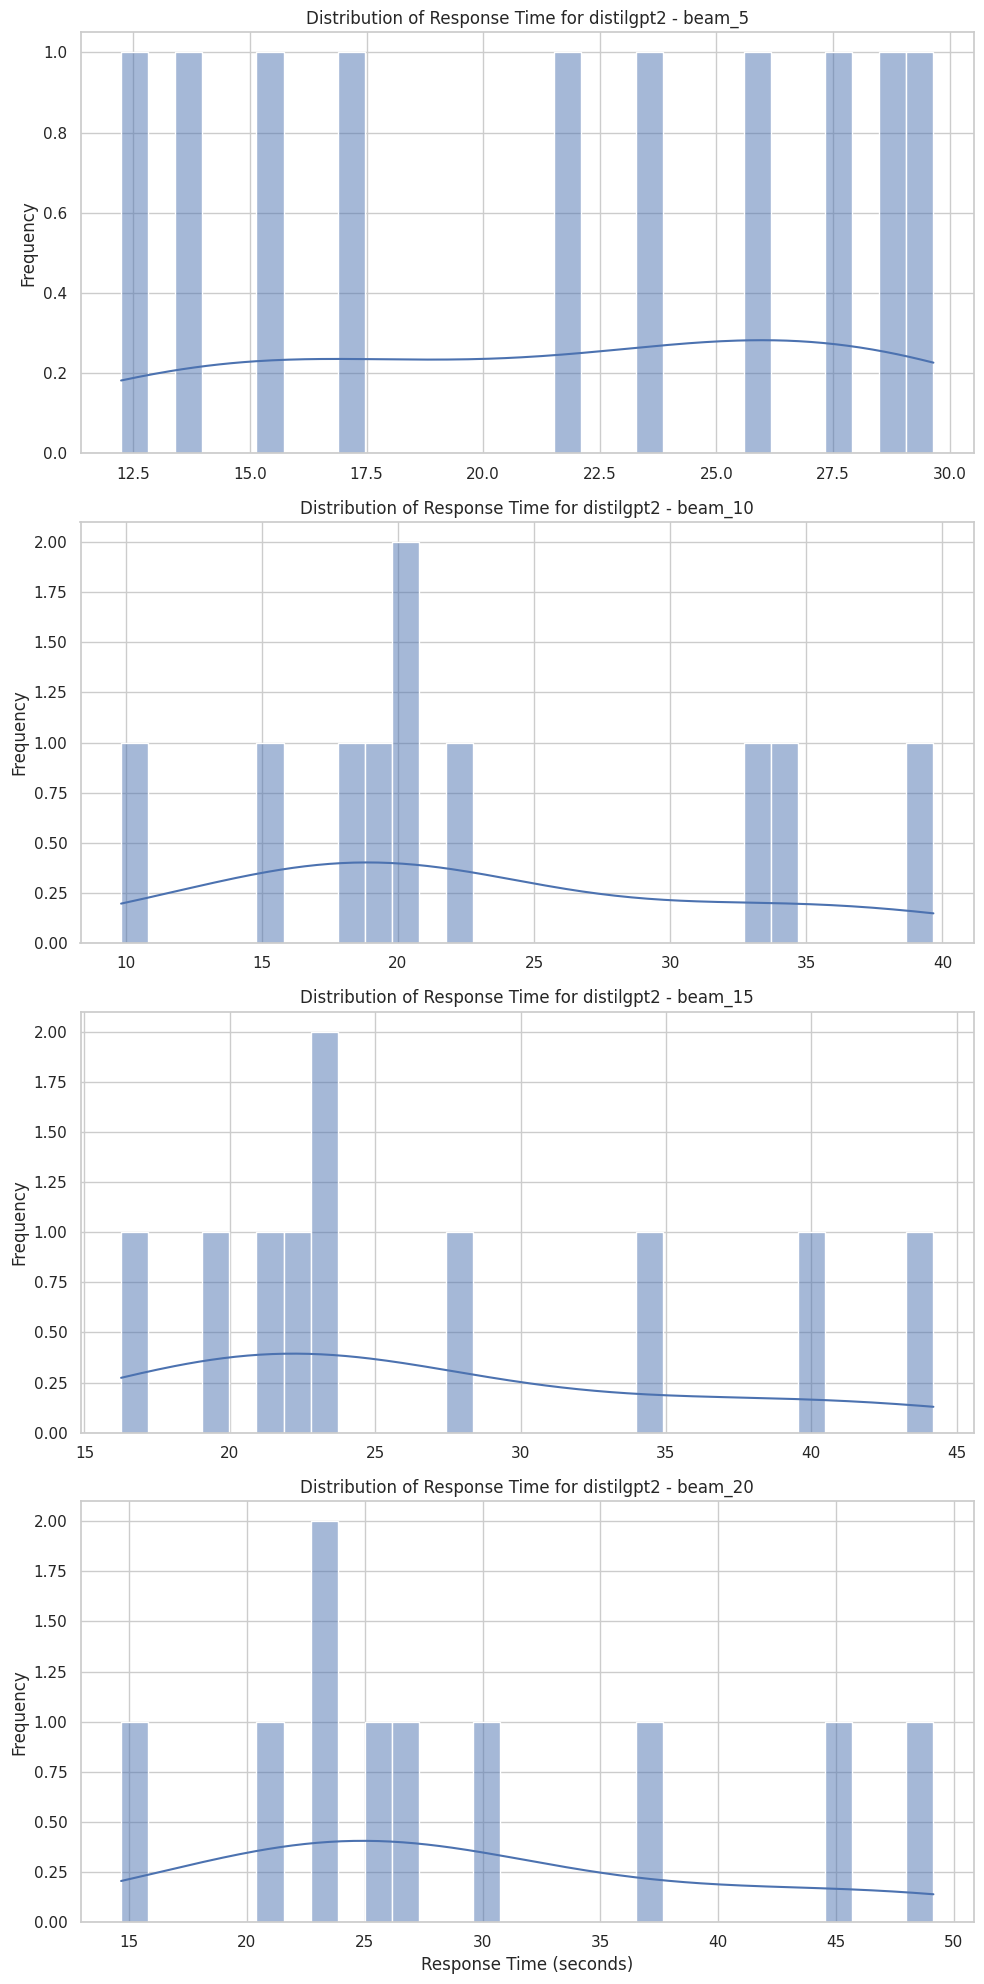

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'distilgpt2'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for distilgpt2 - beam 5,10,15,20

The four histograms above individually display the distribution of response times for the "distilgpt2" model across different beam sizes during a sequence generation task.

In the Beam Size 5 Histogram, the response times ranges from about 12.5 to 30 seconds. The distribution shows multiple peaks, possibly indicating a multimodal pattern, at intervals around 15, 20, 25, and 30 seconds. This suggests clusters of common response times. The kernel density estimate, which provides a smooth line through the data, further indicates that there are several dominant response times. Moving to the Beam Size 10 Histogram, we see response times extending from approximately 10 to 40 seconds. This distribution is more dispersed compared to the beam size 5 histogram, with several less pronounced peaks. This wider spread of times implies greater variability in response times at this beam size.

The Beam Size 15 Histogram exhibits response times from roughly 15 to 45 seconds. This histogram, too, is multimodal but with peaks that are less distinct compared to the beam size 10 histogram. Notable peaks are observed around 20, 30, and 40 seconds. The distribution flattens as the beam size increases, implying more variation in response times. In the Beam Size 20 Histogram, response times have broadened further, ranging from about 15 to 50 seconds. This histogram continues the trend of being multimodal, with peaks around 20, 35, and 45 seconds. The increased spread and the kernel density estimate suggests that response times become less predictable with larger beam sizes.

When analysing these histograms as a whole, several trends come to light:

- There is a consistent increase in the range of response times as beam size grows, mirroring the patterns seen in previous analyses. This possibly indicates that a larger beam size generally leads to a wider array of possible response times and that they become less predictable.
- Despite the varying beam sizes, a mode around 20 seconds is consistently observed across all histograms, possibly signifying a baseline response time for certain computations regardless of the beam size.
- The skewness in the distributions is not uniform. While the first histogram appears slightly right-skewed, this pattern is less evident in the subsequent histograms. However, the presence of long tails in all distributions could suggest that instances of much longer response times occasionally occur.
- Increased variability in response times is noted with larger beam sizes, leading to more frequent occurrences of unusually long or short response durations.
- These histograms imply that as the beam size increases, so does the unpredictability in response times. This factor is crucial for applications requiring consistent and predictable response times.

Overall, the trend from these histograms indicates that as beam size increases, the distribution of response times for the "distilgpt2" model becomes wider with increased variability. The "distilgpt2" model shows considerably lower response times, suggesting higher efficiency in terms of response speed. However, an increase in beam size tends to extend both the potential response time and its variability, thus affecting the predictability of the model's performance as seen similar analysis below.

# Generation of graph for distribution of response time for google/bert_for_seq_generation_L-24_bbc_encoder beam 5-20

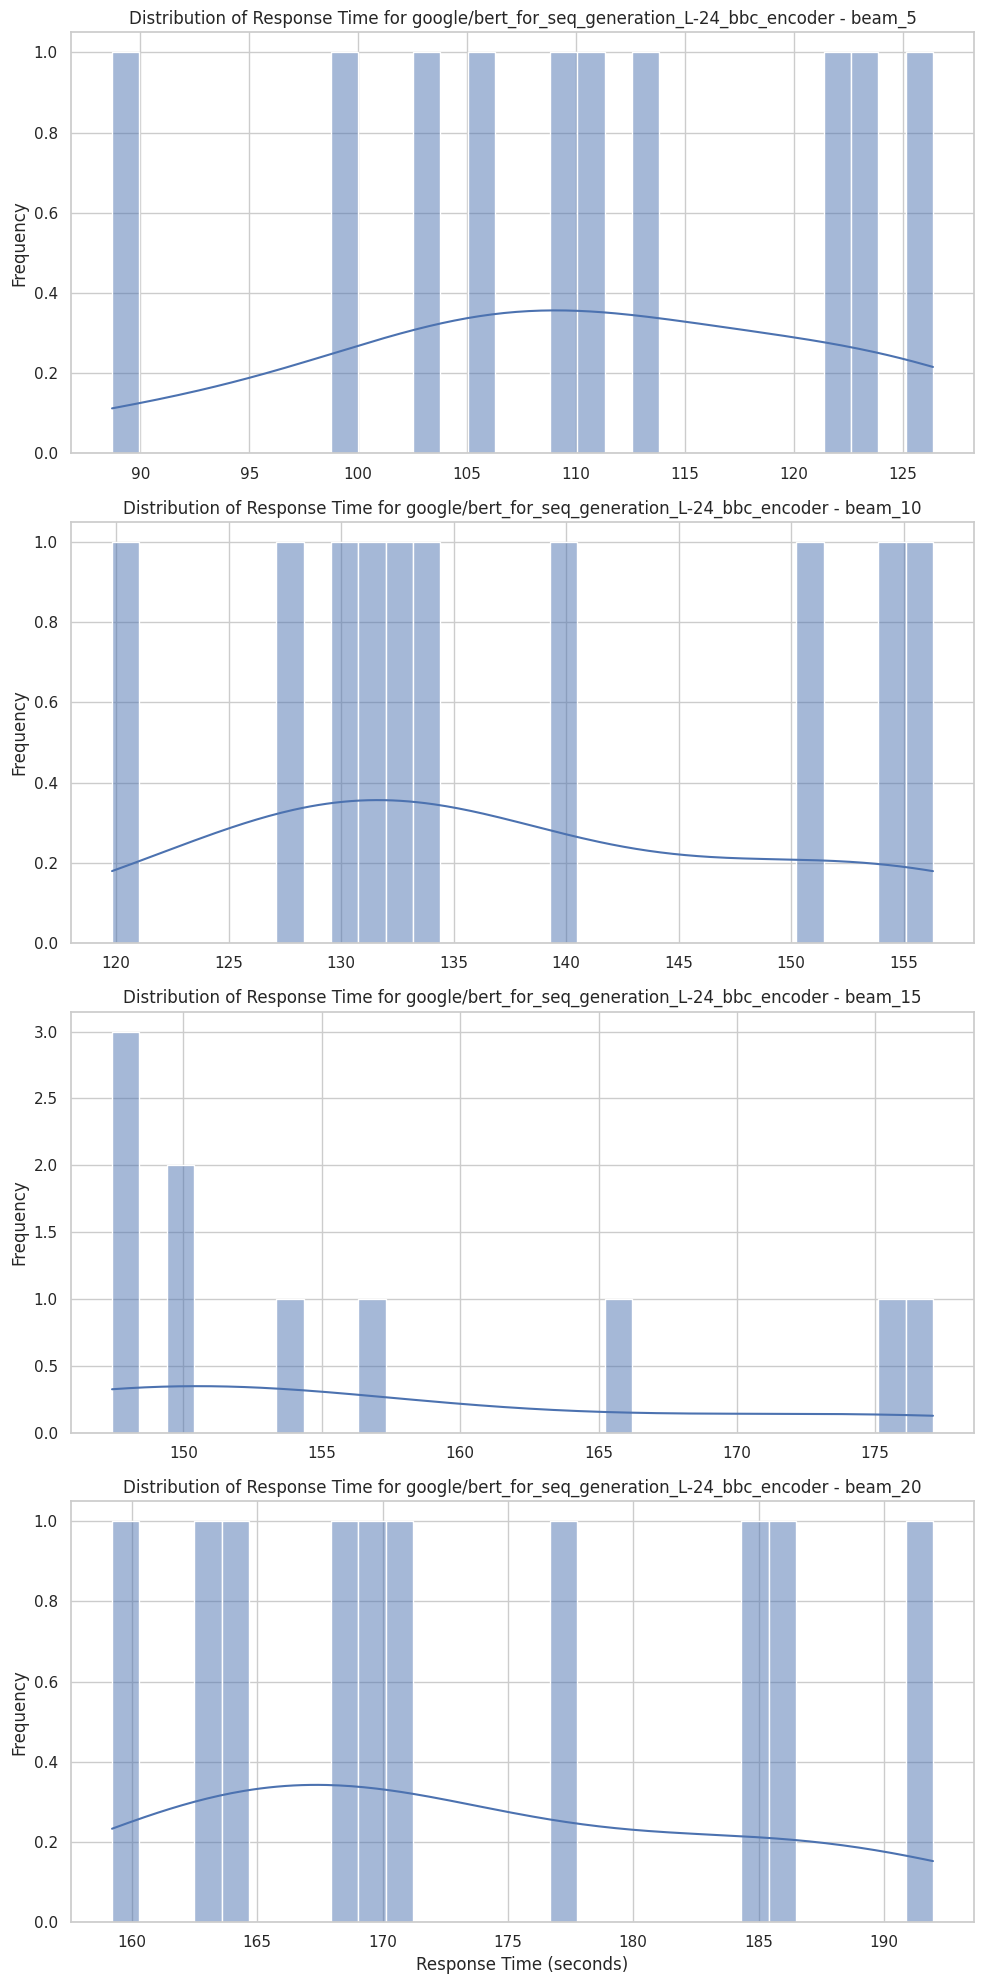

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'google/bert_for_seq_generation_L-24_bbc_encoder'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for google/bert_for_seq_generation_L-24_bbc_encoder - beam 5,10,15,20

In the provided histograms above, we observe the distribution of response times for a sequence generation task using the model stated above at varying beam search sizes. Each histogram is analyzed individually, followed by a combined analysis to understand overarching trends.

The Beam Size 5 Histogram reveals response times predominantly ranging from 90 to 125 seconds. The distribution appears multimodal, with notable peaks around 95, 105, and 120 seconds. A kernel density estimate line suggests several local maxima, confirming the multimodal nature of the distribution. Moving to the Beam Size 10 Histogram, response times extend from approximately 120 to 155 seconds. Compared to the first histogram, this distribution is less multimodal, with a more distinct peak at around 130 seconds. The right-skewed distribution indicates that as the beam size increases, instances of longer response times become more frequent.

In the Beam Size 15 Histogram, response times vary more broadly, spanning from about 150 to 175 seconds. This distribution is more spread out with multiple peaks, signifying variability in response times. The kernel density line in this histogram shows a less defined pattern, indicating decreased predictability in response times as the beam size grows. The Beam Size 20 Histogram displays response times approximately between 160 and 190 seconds. This distribution has peaks at the extremes, suggesting frequent response times around 165 seconds or near 190 seconds. Notably, there is a gap in the middle range (175-185 seconds), where fewer instances occur than expected.

When analyzing these diagrams collectively, several key insights come to light:

- A clear trend of widening response time ranges is evident as beam size increases from 5 to 20. This widening suggests that larger beam sizes contribute to greater variability and generally longer response times.
- The mode of the distributions shifts rightward with increasing beam size, aligning with the expectation that larger beam sizes lead to longer response times due to heightened computational demands.
- The distributions evolve from being multimodal with smaller beam sizes to becoming more varied and spread out with larger beam sizes. Skewness generally increases, evident from longer tails to the right, typical in processes where minimum times exist, but some cases can take considerably longer.
- From a performance standpoint, minimizing response time would favor smaller beam sizes within the beam search. However, selecting the appropriate beam size often involves a trade-off between speed and sequence generation quality, where larger beam sizes could have higher quality, however, this comes with increased response times.
- The variability in response times also appears to escalate with beam size, implying the need for wider prediction intervals for response times with larger beams.
- The uneven distributions and gaps in the larger beam size histograms (15 and 20) suggest either potential anomalies or specific conditions under which the model's sequence generation time varies significantly.

Overall, the analysis indicates a pronounced pattern where increasing the beam size not only increases the response time but also introduces increased variability. This pattern is crucial for optimizing sequence generation tasks, needing for a balanced approach between output quality and computational resources and time constraints.

# Graph Generation for gpt2 beam 5-20

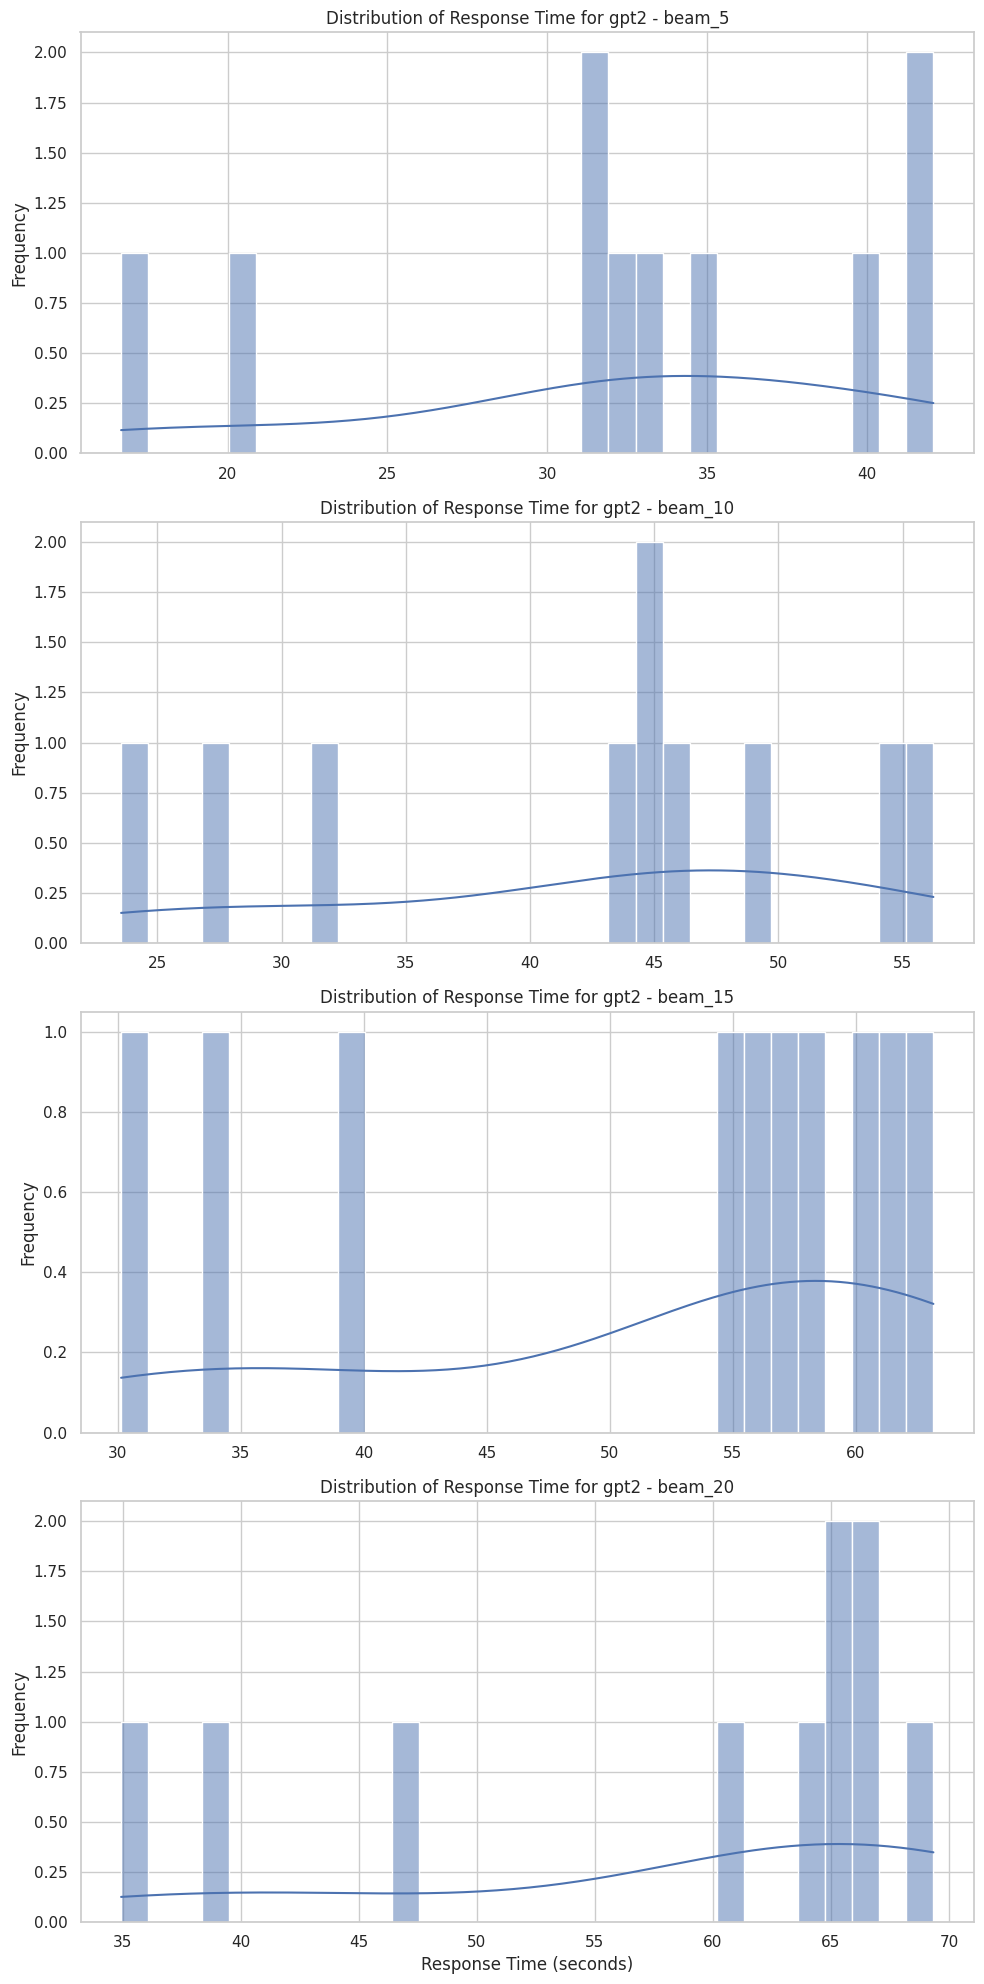

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'gpt2'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for gpt2 - beam_5,10,15,20

The chart above contains histograms displaying the distribution of response times for the GPT-2 model using various beam widths. In the Beam_5 Histogram, the response times are concentrated within a few intervals, indicating that certain response times are more common, as suggested by the peaks in the distribution. The range of these response times appears to be between 15 and 40 seconds, and the distribution seems to be multimodal, showing several distinct peaks. The Beam_10 Histogram shows that response times are spread over a wider range compared to beam_5, indicative of increased variability with a higher beam width. The response times seem to range from approximately 25 to 55 seconds. This histogram also appears to be multimodal with multiple prominent peaks.

Moving on to the Beam_15 Histogram, there is an extension in the range of response times, potentially ranging from about 25 seconds to over 55 seconds. Unlike the beam_5 and beam_10 histograms, the peaks are less significant here, suggesting a more uniform distribution across the measured response times. A slight right skew is observed, although it is less pronounced than might be expected with an increased beam width. In the Beam_20 Histogram, the response times are distributed across an even broader range, from roughly 35 seconds to 70 seconds. This histogram exhibits a more noticeable right skew, with a longer tail extending towards higher response times. Like the previous histograms, this distribution also appears to be somewhat multimodal.

Collectively analyzing all histograms, several observable trends emerge. There is a clear increase in both the range and variability of response times as the beam width increases from beam_5 to beam_20. This trend suggests that the algorithm takes longer and becomes less predictable with wider beams, likely due to evaluating more candidate sequences. Each histogram's multimodal nature might imply that the GPT-2 model has several 'typical' response times under different conditions or prompts. A trend of increasing right skewness with larger beam widths is also observed. This skewness is typical of distributions with a natural lower bound such as time and no upper bound, where high values are occasionally possible. Finally, the modes of the distributions shift to the right as the beam width increases, confirming that larger beam widths generally result in longer average response times.

The observed increase in response time with beam width aligns with the theoretical expectations of the beam search algorithm. As the beam widens, the model keeps more sequences for consideration at each generation step, requiring more computation. The multimodal distributions could reflect different typical response times based on various prompt types or content, leading to clusters of response times. The right skewness indicates that while there is a common range of response times, outliers or specific scenarios can significantly prolong the model's response. The mode shifting to higher response times with wider beams possibly suggests that not only do maximum response times increase, but the most frequently observed response times also become lengthier.

Overall, these histograms collectively depict a pattern of increasing response time with wider beam widths, providing crucial insights for balancing computational resources and text generation quality. While longer response times with wider beams might be acceptable for enhanced output quality, narrower beams could be preferred in time-sensitive applications, despite potential compromises in output diversity or quality.

# Distribution of response time for openai-gpt beam 5-20

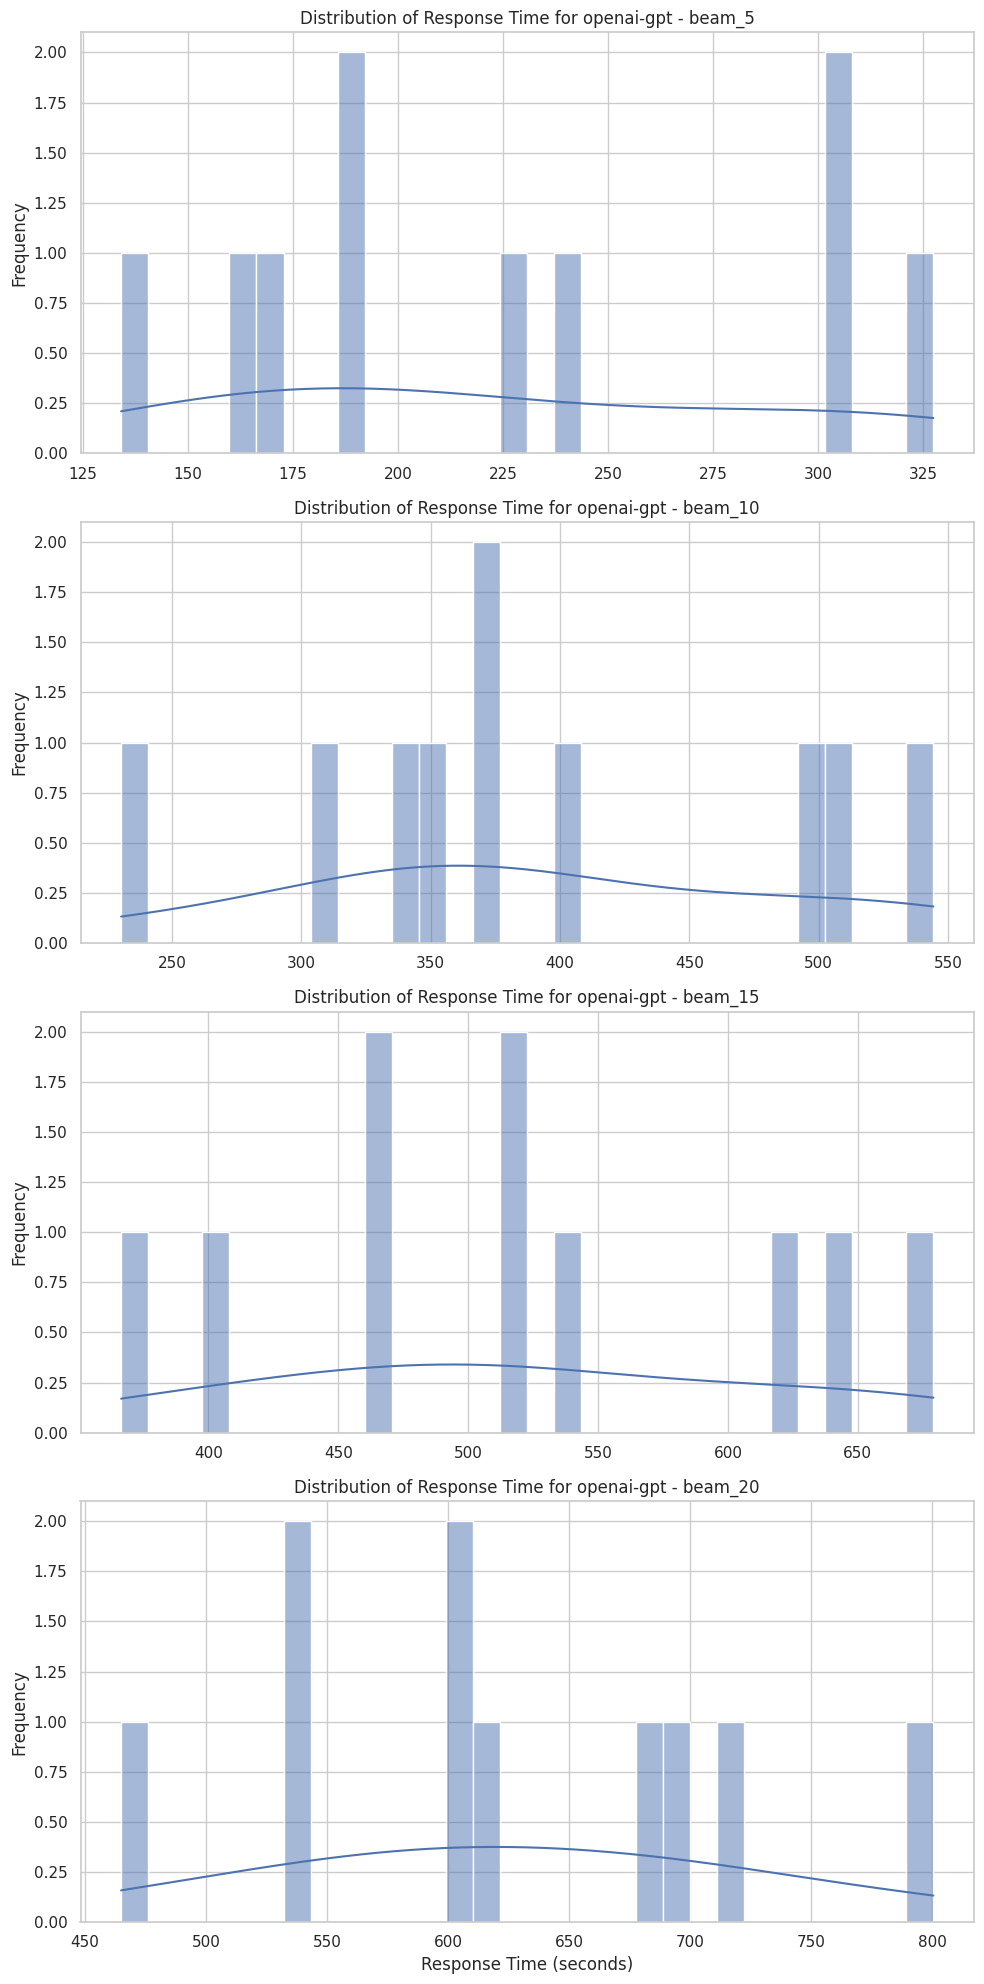

In [ ]:
# Step 2: Read the File
data = pd.read_csv('output_beam.csv')

# Step 3: Run the Analysis
# The checkpoint to filter by
specific_checkpoint = 'openai-gpt'

# Beam types to consider
beam_types = ['beam_5', 'beam_10', 'beam_15', 'beam_20']

# Creating a figure for multiple histograms with adjusted dimensions
# Reduced width and increased height
plt.figure(figsize=(10, 20))  # Adjusted figsize

for i, beam_type in enumerate(beam_types):
    # Filter data for each beam type under the specific checkpoint
    filtered_data = data[(data['checkpoint'] == specific_checkpoint) & (data['type'] == beam_type)]

    # Creating a subplot for each histogram
    plt.subplot(len(beam_types), 1, i + 1)
    sns.histplot(filtered_data['time'], bins=30, kde=True)
    plt.title(f'Distribution of Response Time for {specific_checkpoint} - {beam_type}')
    plt.xlabel('Response Time (seconds)' if i == len(beam_types) - 1 else '')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Distribution of Response Time for openaio-gpt - beam_5,10,15,20

The graphs above illustrate the frequency (on the y-axis) of various response times (on the x-axis), measured in seconds, for four distinct beam widths: beam_5, beam_10, beam_15, and beam_20.

The Beam_5 Histogram shows response times primarily clustered between 175 and 325 seconds, with multiple peaks indicating certain response times are more common. The distribution appears slightly right-skewed, suggesting an extension towards longer response times. In the Beam_10 Histogram, the distribution of response times is observed between approximately 250 and 550 seconds. The spread of these response times is broader than in the beam_5 histogram, implying increased variability as the beam width expands. There is also noticeable right skewness, with an elongated tail pointing towards higher response times.

The Beam_15 Histogram exhibits a wide range of response times, from about 400 to 650 seconds. This spread is wider compared to the beam_5 and beam_10 histograms, indicating further increased variability with a higher beam width. The distribution here is also right-skewed, with some response times significantly exceeding the mode. In the Beam_20 Histogram, response times vary even more broadly, approximately from 450 to 800 seconds. The variability and range of response times continue to escalate with the beam width. This histogram also shows significant right skewness, indicating that higher beam widths are associated with some notably long response times.

When analyzing all histograms collectively, several trends can be observed. There is a clear trend of increasing response time as the beam width grows from beam_5 to beam_20. This aligns with expectations, as a larger beam width requires the model to evaluate more candidate sequences at each step, increasing computational demands. The variability in response times also rises with beam width, suggesting that the model's computation time becomes less predictable as it evaluates more candidates. Each distribution exhibits right skewness, a common characteristic in performance metrics like response times. This skewness intensifies with the beam width, suggesting an increased likelihood of encountering longer response times as more paths are considered during generation. The mode, or the most frequent response times, shifts rightward with increasing beam width, reinforcing the observation that larger beam widths generally result in lengthier average response times.

The increase in response time and variability with larger beam widths is consistent with the theoretical understanding of the beam search algorithm, where a wider beam entails keeping more sequences in memory. This can lead to potentially higher output quality but requires additional computation. The right skewness of the distributions possibly indicates that, while most response times might cluster around a mode, there are instances where the response time can be significantly longer, especially in complex scenarios requiring the evaluation of numerous divergent sequences.

Overall, these histograms suggest that increasing the beam width in a beam search not only leads to longer average response times but also raises the possibility of encountering outlier response times substantially longer than the average. This insight is crucial for optimizing the balance between text generation quality and computational efficiency, particularly in real-world applications where resource constraints or response time is a key consideration.

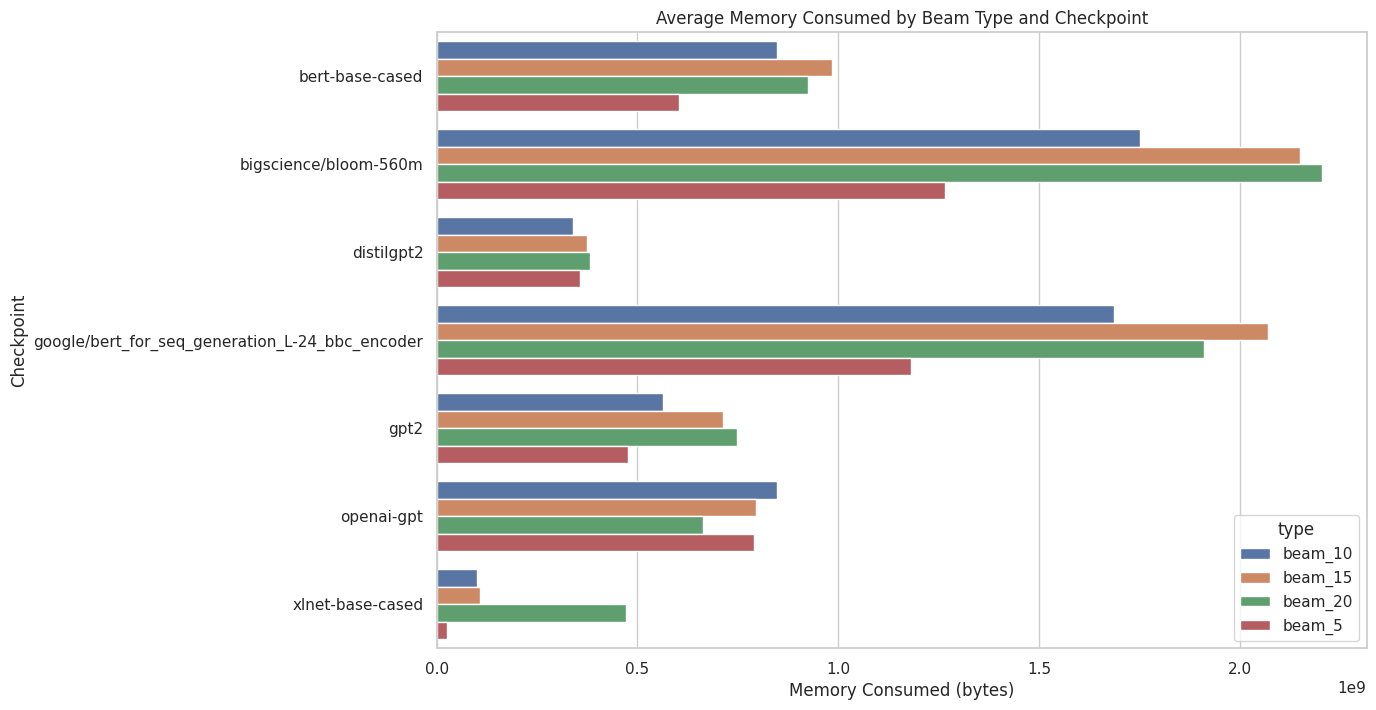

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data = pd.read_csv('output_beam.csv')

# Group the data by 'type' and 'checkpoint' and calculate the mean for relevant columns
grouped_data = data.groupby(['type', 'checkpoint']).agg({
    'time': 'mean',
    'mem_before': 'mean',
    'mem_after': 'mean',
    'consumed': 'mean',
    'model_parameters': 'mean'
}).reset_index()

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a figure and axis for the plot
plt.figure(figsize=(12, 8))

# Plotting Average Memory Consumed by Beam Type and Checkpoint
sns.barplot(x='consumed', y='checkpoint', hue='type', data=grouped_data)

# Setting the title and labels
plt.title('Average Memory Consumed by Beam Type and Checkpoint')
plt.xlabel('Memory Consumed (bytes)')
plt.ylabel('Checkpoint')

# Display the plot
plt.show()


##Average Memory Consumed by Beam Type and Checkpoint

The bar chart above shows the average memory consumption in bytes for a range of language models, evaluated across different beam widths (5, 10, 15, 20). Each language model, identified as a checkpoint, is represented through four bars, each indicating the memory consumed at varying beam widths during the generation process.

A key insight from the chart is the correlation between memory consumption and beam width. It is observed that for all models, as the beam width increases, so does the average memory consumption. This increase is expected since a broader beam width requires the model to store and process a greater amount of data, particularly candidate sequences, at every step of sequence generation. The chart also highlights variations in model efficiency in terms of memory usage. Notably, the xlnet-base-cased model depicts the most efficient memory usage, consuming the least amount of memory across all beam widths. This contrasts with models like bigscience/bloom-560m and gpt2, which are characterized by significantly higher memory consumption which makes it memory inefficient.

Furthermore, the impact of beam width on memory consumption is not uniform across all models. Models such as distilgpt2 and google/bert_for_seq_generation_L-24_bbc_encoder demonstrates a relatively moderate increase in memory usage with the expansion of beam width. In contrast, models like openai-gpt show a more significant increase, indicating a higher sensitivity to changes in beam width in terms of memory usage.

An interesting observation is the substantial memory consumption of the bigscience/bloom-560m model at a beam width of 20. This suggests that it might be an exceptionally large and complex model or that it generates a significant amount of data during the beam search process, necessitating additional memory. Conversely, the transition from a beam width of 15 to 20 in the xlnet-base-cased model marks one of the smallest increases in memory consumption. This finding is consistent with the overall pattern of efficient memory usage displayed by this model.

The overall trends in the graph indicate that larger models or those with more parameters tend to consume more memory during the beam search process. The incremental memory cost associated with increasing the beam width also varies by model, with some showing a near-linear increase and others exhibiting a more exponential growth in memory consumption. This graph offers valuable insights into the memory efficiency of various language models during the generation process. When selecting models for deployment in environments with memory constraints, it is essential to consider not only their computational efficiency, as indicated in previous graphs, but also their memory footprint. Models such as xlnet-base-cased, which demonstrate efficient memory usage, may be particularly advantageous in scenarios where memory usage is a critical concern.

# **Conclusion:**

In conclusion, this report has conducted an extensive analysis of various language models, providing valuable insights into their performance, particularly in the context of memory consumption, text generation durations, and model parameters. The study has highlighted the complexity and intricacies of these models, hightlighting the delicate balancing act required to optimize their efficiency and effectiveness.

**Model Parameters**\
The comparison of model parameters, such as in the "bert-base-cased," "bigscience/bloom-560m," and "distilgpt2" models, revealed significant variations in computational demands and capabilities. Understanding these parameters is crucial, as they directly influence a model's ability to process and generate language, impacting its suitability for specific tasks.

**Memory Consumption**\
The analysis of memory consumption, both before and after text generation, has offered insights into the resource efficiency of each model. Models with higher memory requirements may pose challenges in resource-constrained environments but could offer more sophisticated capabilities. Conversely, models with lower memory consumption might be preferable in applications where resources are limited, even if this means a trade-off in terms of complexity or depth of text generation.

**Text Generation Durations**\
The investigation into text generation durations, particularly the effects of beam width on response time and the distribution of response times across different generation methods, highlighted the variability in how models respond to different settings. Larger beam widths generally lead to longer response times, suggesting a trade-off between the quality of the generated text and the speed of generation.

**Balancing Act**\
Choosing the right model involves a balancing act between these various factors. For real-world applications, the selection hinges on the specific requirements of the task at hand. In time-sensitive scenarios, faster models with shorter text generation durations may be preferable. In contrast, applications that prioritize the quality or depth of text generation may benefit from more complex models, despite longer response times and higher memory consumption.

**Real-World Applications and Model Selection**\
Language models are integral in a myriad of real-world applications, from automated customer service chatbots to sophisticated data analysis and natural language processing tasks. The choice of a model should be informed by the specific needs of the application - whether it is speed, accuracy, depth of context, or the ability to handle large volumes of data. Understanding the trade-offs between memory consumption, text generation duration, and model complexity is key to selecting the right model for the right application. This ensures that the chosen model not only performs optimally but also aligns with the logistical constraints and objectives of the task.

In summary, this report not only hightlight the capabilities and limitations of various pre-trained language models but also guides the strategic selection and application of these models in real-world scenarios. By carefully considering model parameters, memory consumption, and text generation durations, one can effectively navigate the trade-offs to select a model that best fits the specific requirements of their application.